# 🏠 House Prices (Kaggle Competition)

**Goal:** Predict `SalePrice` for Ames, Iowa homes using tabular machine learning.  

**Evaluation Metric:** RMSE on `log1p(SalePrice)` (log-space RMSE).  

**Highlights:**  
- Comprehensive **data cleaning and preprocessing pipeline**, including handling of missing values, categorical encoding, and feature scaling.  
- Detailed **feature analysis** and engineering.  
- Exploration of **baseline and tuned regression models**: Linear Regression, Ridge, Lasso, Decision Tree, Random Forest, XGBoost.  
- **Residual analysis** in both log-space and dollar-space to assess prediction errors.  
- **Learning curves** to visualize bias-variance trade-offs and model generalization.  
- Final Kaggle submission tested with **both Lasso and XGBoost**, achieving top ~6% ranking among participants.  

> This notebook demonstrates an end-to-end approach to tabular data prediction, from preprocessing to model evaluation and competition submission.

## 📚 Notebook Outline

1. Introduction **(done)**
2. Loading and Exploring the Dataset
3. Feature Engineering & Preprocessing
4. Baseline Models (Linear Regression, Ridge, Lasso)
5. Tree-Based Models (Decision Tree, Random Forest, XGBoost)
6. Final Model Choice
7. Save Models & Preprocessing Pipeline
8. Final Predictions for Kaggle Submission
9. Extended Experiments: CatBoost
10. Extended Experiments: Model Ensembles

## 1. Introduction

Predicting house prices is a classic problem in machine learning with practical applications in real estate, mortgage lending, and property investment. This notebook tackles the Kaggle "Housing Prices Competition for Kaggle Learn Users" competition, which challenges participants to predict the **final sale price** of homes in **Ames, Iowa**.

The dataset includes **79 explanatory variables** describing nearly every aspect of residential homes, from lot size and year built to neighborhood and basement characteristics. This richness allows us to explore a variety of regression techniques and workflows.

This project demonstrates an **regression workflow**, covering:

- Data exploration and feature engineering  
- Baseline and advanced regression modeling  
- Rigorous cross-validation and hyperparameter tuning  
- Model interpretability using feature importance and SHAP values  
- Optional ensembling to improve performance  

🔗 [Kaggle Housing Prices Competition Link](https://www.kaggle.com/competitions/home-data-for-ml-course/overview)

The evaluation metric is **RMSE on log-transformed sale prices**.

This notebook shows how to approach a real-world regression problem, from data preparation to interpretable, production-ready modeling.

## 2. Loading and Exploring the Dataset

In this section, we load the dataset and perform initial exploration to understand its structure, check for missing values, and get a sense of the features’ distributions. We also briefly examine the target variable (`SalePrice`) to understand its scale and variability, which will guide preprocessing and modeling decisions.

### 2.1 Importing Libraries

We begin by importing the essential Python libraries for data loading, manipulation, visualization, and machine learning:

In [80]:
# Data manipulation
import pandas as pd
import numpy as np

# Data loading
import kagglehub
import tarfile
import urllib.request
import os

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style('whitegrid')

# stats
from scipy.stats import skew
from scipy import stats

#iterators
from itertools import product

# Machine learning libraries (sklearn and xgboost)
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV, learning_curve, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

# CatBoost library (extended experiments Section 9)
from catboost import CatBoostRegressor, Pool, cv

# save pipeline and models
import joblib

### 2.2 Loading the Dataset

We start by loading the training and test datasets provided by the Kaggle competition. After loading, we display the first few rows to get a quick look at the data structure.

> Notes: 
> - Since this is a Kaggle competition, the train/test split is already provided; we do **not** need to create a separate split manually.
> - The *training set* contains both the features and the target variable.
> - The *test set* contains only the features, as it is meant for making predictions to submit to the Kaggle competition.

The dataset contains **79 features** describing various aspects of residential homes, plus the target variable `SalePrice`:
- **SalePrice**: the property's sale price in dollars. This is the target variable that you're trying to predict.

<details> <summary>Click to expand full list of features:</summary>

- **SalePrice**: the property's sale price in dollars. This is the target variable that you're trying to predict.
- **MSSubClass**: The building class
- **MSZoning**: The general zoning classification
- **LotFrontage**: Linear feet of street connected to property
- **LotArea**: Lot size in square feet
- **Street**: Type of road access
- **Alley**: Type of alley access
- **LotShape**: General shape of property
- **LandContour**: Flatness of the property
- **Utilities**: Type of utilities available
- **LotConfig**: Lot configuration
- **LandSlope**: Slope of property
- **Neighborhood**: Physical locations within Ames city limits
- **Condition1**: Proximity to main road or railroad
- **Condition2**: Proximity to main road or railroad (if a second is present)
- **BldgType**: Type of dwelling
- **HouseStyle**: Style of dwelling
- **OverallQual**: Overall material and finish quality
- **OverallCond**: Overall condition rating
- **YearBuilt**: Original construction date
- **YearRemodAdd**: Remodel date
- **RoofStyle**: Type of roof
- **RoofMatl**: Roof material
- **Exterior1st**: Exterior covering on house
- **Exterior2nd**: Exterior covering on house (if more than one material)
- **MasVnrType**: Masonry veneer type
- **MasVnrArea**: Masonry veneer area in square feet
- **ExterQual**: Exterior material quality
- **ExterCond**: Present condition of the material on the exterior
- **Foundation**: Type of foundation
- **BsmtQual**: Height of the basement
- **BsmtCond**: General condition of the basement
- **BsmtExposure**: Walkout or garden level basement walls
- **BsmtFinType1**: Quality of basement finished area
- **BsmtFinSF1**: Type 1 finished square feet
- **BsmtFinType2**: Quality of second finished area (if present)
- **BsmtFinSF2**: Type 2 finished square feet
- **BsmtUnfSF**: Unfinished square feet of basement area
- **TotalBsmtSF**: Total square feet of basement area
- **Heating**: Type of heating
- **HeatingQC**: Heating quality and condition
- **CentralAir**: Central air conditioning
- **Electrical**: Electrical system
- **1stFlrSF**: First Floor square feet
- **2ndFlrSF**: Second floor square feet
- **LowQualFinSF**: Low quality finished square feet (all floors)
- **GrLivArea**: Above grade (ground) living area square feet
- **BsmtFullBath**: Basement full bathrooms
- **BsmtHalfBath**: Basement half bathrooms
- **FullBath**: Full bathrooms above grade
- **HalfBath**: Half baths above grade
- **Bedroom**: Number of bedrooms above basement level
- **Kitchen**: Number of kitchens
- **KitchenQual**: Kitchen quality
- **TotRmsAbvGrd**: Total rooms above grade (does not include bathrooms)
- **Functional**: Home functionality rating
- **Fireplaces**: Number of fireplaces
- **FireplaceQu**: Fireplace quality
- **GarageType**: Garage location
- **GarageYrBlt**: Year garage was built
- **GarageFinish**: Interior finish of the garage
- **GarageCars**: Size of garage in car capacity
- **GarageArea**: Size of garage in square feet
- **GarageQual**: Garage quality
- **GarageCond**: Garage condition
- **PavedDrive**: Paved driveway
- **WoodDeckSF**: Wood deck area in square feet
- **OpenPorchSF**: Open porch area in square feet
- **EnclosedPorch**: Enclosed porch area in square feet
- **3SsnPorch**: Three season porch area in square feet
- **ScreenPorch**: Screen porch area in square feet
- **PoolArea**: Pool area in square feet
- **PoolQC**: Pool quality
- **Fence**: Fence quality
- **MiscFeature**: Miscellaneous feature not covered in other categories
- **MiscVal**: $Value of miscellaneous feature
- **MoSold**: Month Sold
- **YrSold**: Year Sold
- **SaleType**: Type of sale
- **SaleCondition**: Condition of sale

</details>

In [5]:
# Load the CSV file (train and test sets) into DataFrames
house_train = pd.read_csv("datasets/houseprices_train.csv", index_col=0)
house_test = pd.read_csv("datasets/houseprices_test.csv", index_col=0)

print("Train set DataFrame loaded with index_col=0:")
display(house_train.head())

# Split features and target
X_train = house_train.drop("SalePrice", axis=1)
y_train = house_train["SalePrice"].copy()

X_test = house_test.copy()

print(f"Dataset shape: {house_train.shape}")

Train set DataFrame loaded with index_col=0:


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Dataset shape: (1460, 80)


### 2.3 Initial Exploration

Before diving into feature engineering or modeling, it’s important to get a quick overview of the dataset. In this step, we inspect the basic structure, data types, missing values, and summary statistics.

> **Note**: At this stage, we do not explore the target variable extensively, as we will focus first on feature distributions, types, and missing values.

In [6]:
# Display the first few rows to get a sense of the data structure
display(X_train.head())

# Quick overview of data types and missing values
X_train.info()

# Summary statistics for numeric features
X_train.describe().T

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0
BsmtFinSF2,1460.0,46.549315,161.319273,0.0,0.00,0.0,0.00,1474.0


- `.info()` shows the number of non-null entries per column. Comparing these counts to the total number of rows (`1460`) reveals that some features contain missing values and will need to be addressed during preprocessing.

- `.describe()` reveals that features span very different scales (e.g., `LotArea` vs `GrLivArea`), so scaling may be necessary for some models. It also provides an initial idea of potential outliers, but given the dataset’s size and number of features, visual inspection or statistical methods are more practical for identifying them accurately.

> This initial exploration helps us understand the dataset structure and highlights any data cleaning or preprocessing steps that will be required before modeling.

> Note: While `.info()` hints at missing values, a full missing value analysis is provided in the next subsection.

### 2.4 Checking Missing Values, Duplicates and Categorical Feature Overview

Before diving into feature engineering, it's important to understand the completeness and types of the data. In this section, we will:

- Identify which features have missing values and the extent of missingness.
- Get a quick overview of categorical versus numerical features, which will guide encoding and preprocessing decisions later.
- Confirm whether there are any duplicate rows in the dataset.

This initial check helps us plan how to handle missing data and which features may require special treatment.

### 2.4 Checking Missing Values, Duplicates and Categorical Feature Overview

A crucial step in data preparation is identifying missing values and understanding the data types of features. This helps us decide on imputation strategies and preprocessing steps later.

- **Missing values**: Several features contain missing values, with some having a large proportion of missing entries (e.g., `PoolQC`, `MiscFeature`, `Alley`, `Fence`).

- **Categorical vs Numerical features**: The dataset includes **43 categorical** and **37 numerical** features. This distinction will guide us in choosing the right encoding methods (e.g., one-hot encoding for categorical variables) and scaling techniques (e.g., normalization/standardization for numerical variables).

In [7]:
# Check missing values
missing = house_train.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
display(missing)

# Calculate total and percentage of missing values in the dataset
total = np.product(house_train.shape)
total_missing = missing.sum()
percent_missing = (total_missing / total) * 100
print(f"Total missing values: {total_missing}")
print(f"Percentage missing: {percent_missing:.2f}%\n")

# Categorical vs numerical overview
categorical = house_train.select_dtypes(include='object').columns
numerical = house_train.select_dtypes(exclude='object').columns
print(f"Categorical features ({len(categorical)}): {list(categorical)}\n")
print(f"Numerical features ({len(numerical)}): {list(numerical)}\n")

# Check for duplicates
has_duplicates = house_train.duplicated().any()
print(f"Duplicate rows in dataset? {has_duplicates}")

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

Total missing values: 6965
Percentage missing: 5.96%

Categorical features (43): ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']

Numerical features (37): ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'T

**Comments / Observations**:

- **Missing Values**: A subset of features contains missing values. We'll handle these systematically during preprocessing.

- **Categorical vs Numerical features**: The dataset includes 43 categorical and 37 numerical features. This distinction will guide encoding choices (e.g., one-hot or ordinal) and scaling strategies.

- **Duplicates**: There are no duplicate rows in the training set.

### 2.5 Exploratory Data Analysis (EDA)

Before moving on to preprocessing, we take a closer look at the dataset to better understand feature relationships and potential modeling challenges. This step helps us form hypotheses and make informed preprocessing choices later.

- **Target variable (`SalePrice`)**: We check its distribution, look for skewness, and consider transformations if necessary (e.g., log transformation).  
- **Numerical features**: Using correlation analysis, we identify which features are most strongly associated with `SalePrice` and spot possible multicollinearity.   
- **Categorical features**: We examine the cardinality (number of unique categories) and compare how categories relate to `SalePrice` (e.g., boxplots for `Neighborhood`, `OverallQual`).  
- **Outlier detection**: We visually inspect key variables (`GrLivArea`, `LotArea`, `TotalBsmtSF`, etc.) to identify unusual values that could negatively affect model performance. Scatterplots of top predictors vs. the target also help highlight potential outliers. 

> **Goal**: Build intuition about which features are influential, which may need special treatment, and where potential data issues (outliers, skewness) exist.

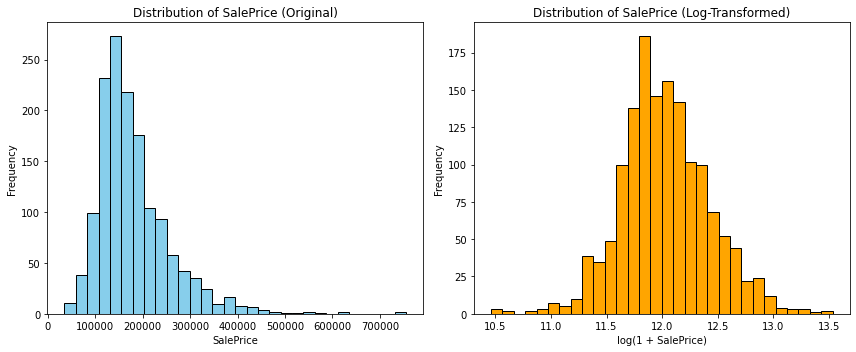

In [8]:
# Plot distribution of SalePrice
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Original SalePrice
axes[0].hist(y_train, bins=30, edgecolor="black", color="skyblue")
axes[0].set_title("Distribution of SalePrice (Original)")
axes[0].set_xlabel("SalePrice")
axes[0].set_ylabel("Frequency")

# Log-transformed SalePrice
y_log = np.log1p(y_train)  # log(1 + x) handles zeros safely
axes[1].hist(y_log, bins=30, edgecolor="black", color="orange")
axes[1].set_title("Distribution of SalePrice (Log-Transformed)")
axes[1].set_xlabel("log(1 + SalePrice)")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

> **Note**: The target variable `SalePrice` is right-skewed. Applying a **log transformation** produces a distribution closer to normal, which generally improves the performance of linear models.

> **Note**: Log transformation also compresses the range of `SalePrice`, reducing the influence of extremely expensive houses. This helps models generalize better instead of being dominated by a few high-priced outliers.

To understand which numerical features are most predictive of house prices, we compute the correlation of each numerical feature with the target variable `SalePrice`. This gives us a leaderboard of the strongest relationships.

In [9]:
# Compute correlations of numerical features with SalePrice
corr_matrix = house_train.corr()

# Sort correlations with SalePrice
saleprice_corr = corr_matrix["SalePrice"].sort_values(ascending=False)

# Display top 15 correlations
saleprice_corr.head(15)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
Name: SalePrice, dtype: float64

Next, to better visualize these relationships and also check for potential multicollinearity between predictors, we plot a correlation heatmap for the top correlated features:

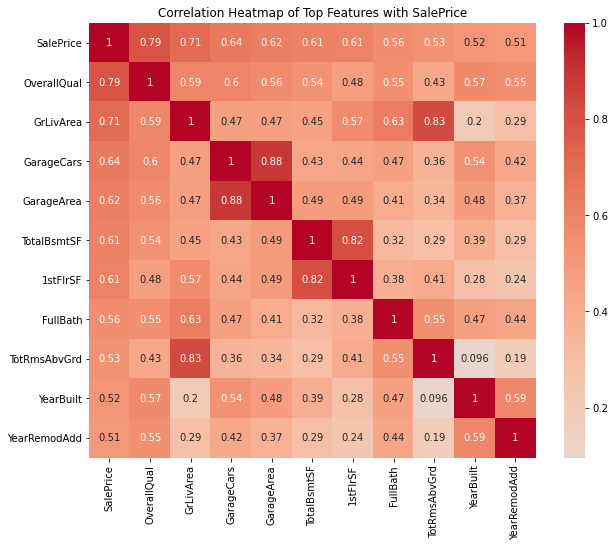

In [10]:
# Select top 10 correlated features with SalePrice
top_features = saleprice_corr.head(11).index  # includes SalePrice itself

# Compute correlation matrix for this subset
plt.figure(figsize=(10,8))
sns.heatmap(house_train[top_features].corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Top Features with SalePrice")
plt.show()

Comments:

- The features `OverallQual` and `GrLivArea` show the strongest positive correlation with `SalePrice`.

- Some features are strongly correlated with each other (e.g., `GarageCars` and `GarageArea`), which indicates potential redundancy.

- This step helps us prioritize features for modeling and guides feature selection or dimensionality reduction later.

Before encoding, it's useful to inspect how many unique categories each categorical feature has. Features with many categories may require special encoding strategies (e.g., target encoding or frequency encoding) to avoid creating a very sparse matrix.

**Categorical Feature Overview**:

Before encoding, it's useful to inspect how many unique categories each categorical feature has. Features with many categories may require special encoding strategies (e.g., target encoding or frequency encoding) to avoid creating a very sparse matrix.

In [11]:
# Number of unique categories per categorical feature
cat_cardinalities = house_train[categorical].nunique().sort_values(ascending=False)
cat_cardinalities

Neighborhood     25
Exterior2nd      16
Exterior1st      15
SaleType          9
Condition1        9
Condition2        8
HouseStyle        8
RoofMatl          8
Functional        7
BsmtFinType2      6
Heating           6
RoofStyle         6
SaleCondition     6
BsmtFinType1      6
GarageType        6
Foundation        6
Electrical        5
FireplaceQu       5
HeatingQC         5
GarageQual        5
GarageCond        5
MSZoning          5
LotConfig         5
ExterCond         5
BldgType          5
BsmtExposure      4
MiscFeature       4
Fence             4
LotShape          4
LandContour       4
BsmtCond          4
KitchenQual       4
MasVnrType        4
ExterQual         4
BsmtQual          4
LandSlope         3
GarageFinish      3
PavedDrive        3
PoolQC            3
Utilities         2
CentralAir        2
Street            2
Alley             2
dtype: int64

**Comments**:

- Features like `Neighborhood` and `Exterior2nd` have many unique categories.

- Features with very few categories (e.g., `CentralAir`) can be safely one-hot encoded without creating too many columns.

- Understanding cardinality helps guide preprocessing decisions and prevents sparse matrices that could degrade model performance.

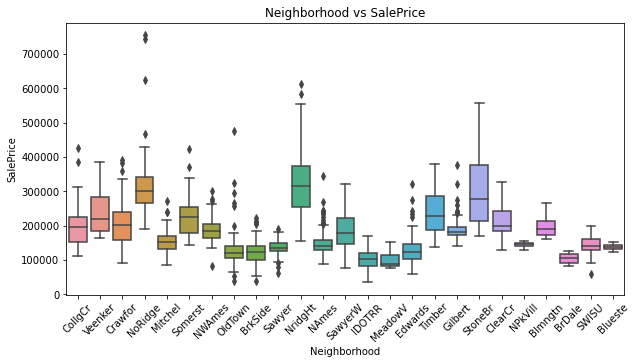

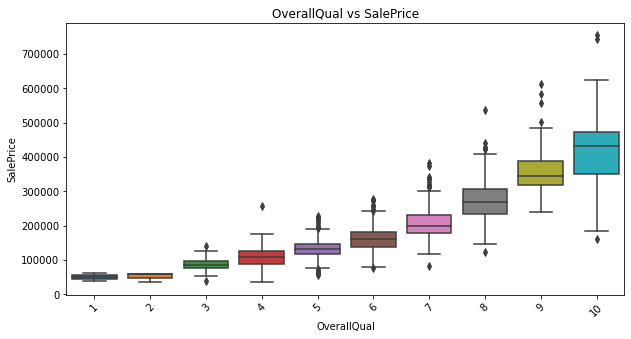

In [12]:
# List of key categorical features to visualize against SalePrice
cat_features = ['Neighborhood', 'OverallQual']

# Loop over features and plot boxplots
for feature in cat_features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=feature, y='SalePrice', data=house_train)
    plt.title(f'{feature} vs SalePrice')
    plt.xticks(rotation=45)
    plt.show()

- These boxplots help visualize how the target variable (`SalePrice`) varies across different categories.

- `OverallQual` shows a strong, clear trend: higher quality correlates with higher prices.

- High-cardinality features like `Neighborhood` may need careful encoding or aggregation to avoid creating overly sparse matrices in modeling.

**Outlier Detection**

We visually inspect key numerical features such as `GrLivArea`, `OverallQual`, and `TotalBsmtSF` to identify extreme values that may negatively impact model performance. While summary statistics like `.describe()` give a rough idea of possible outliers, visual inspection (boxplots, scatter plots) is more effective for spotting unusual entries that require handling.

**Outlier Detection**

To ensure robust model performance, we inspect key numerical features for extreme values that could disproportionately influence predictions. Visualizing these features against the target variable, `SalePrice`, is often more informative than summary statistics alone.

> Scatter plots help reveal these extreme values in context with the target variable. Outlier handling, such as capping or removal, can improve model stability without excessively affecting the majority of the data.

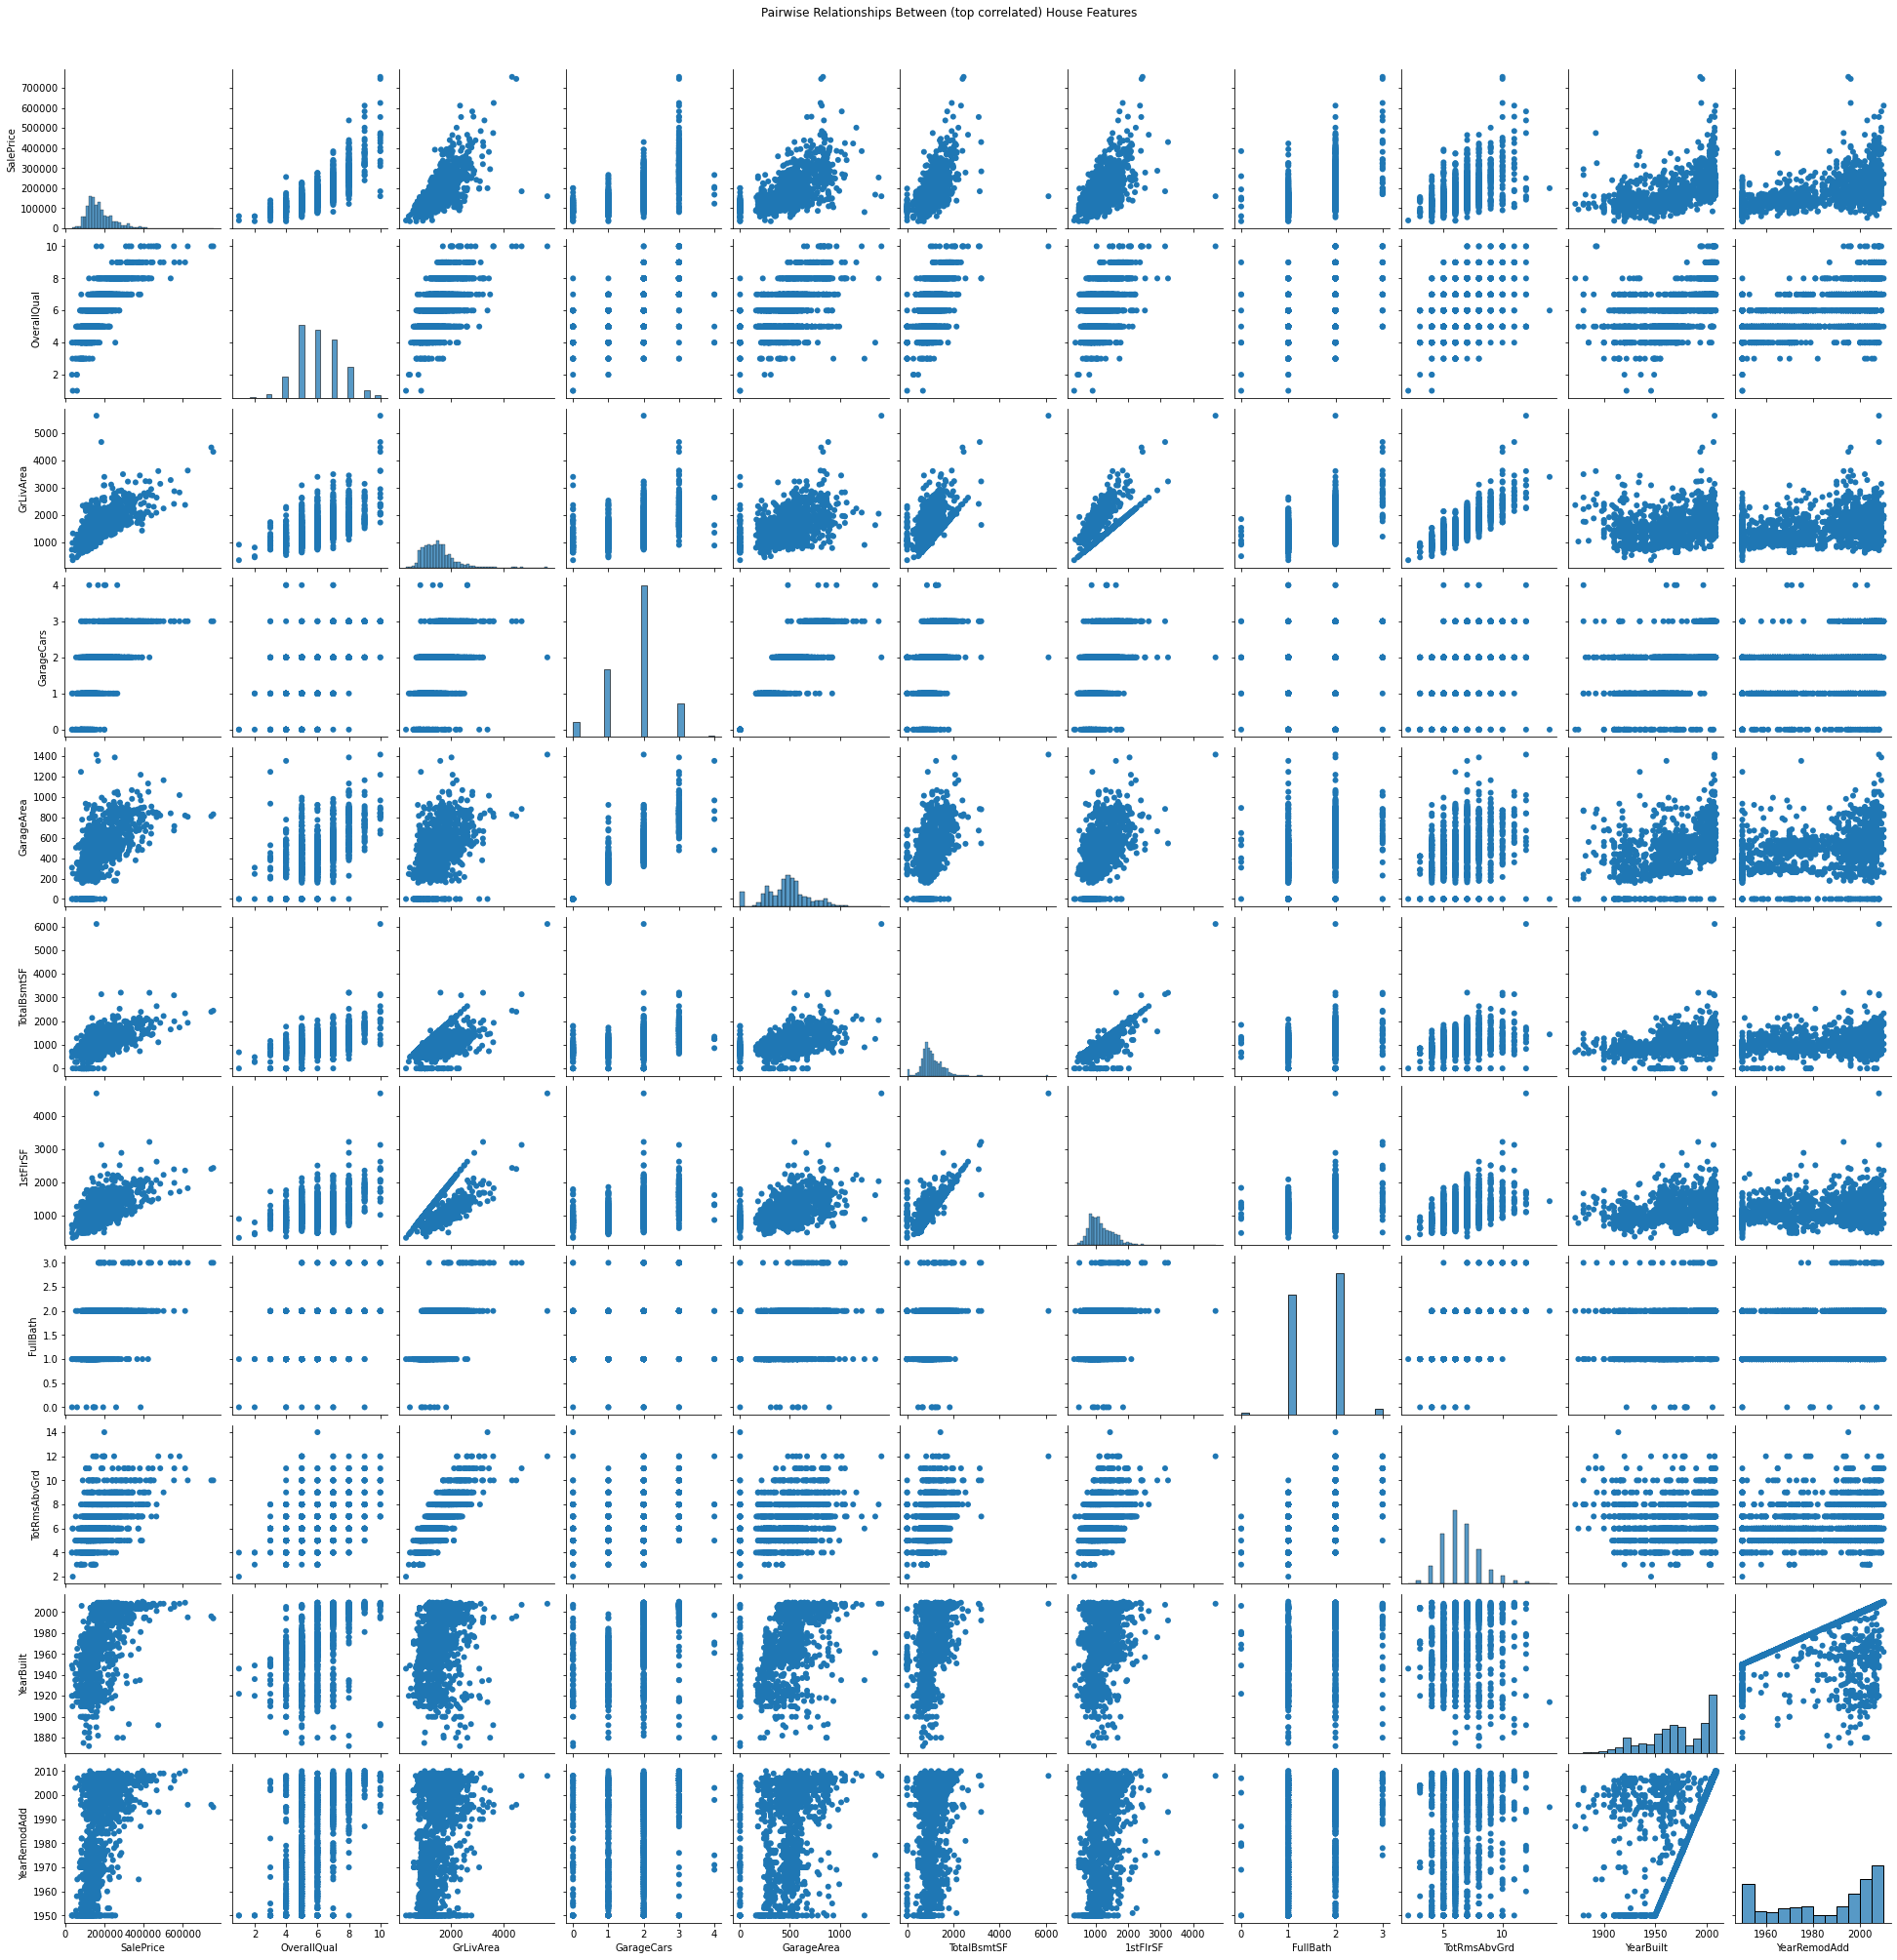

In [13]:
sns.pairplot(house_train[top_features], plot_kws=dict(alpha=1.0, edgecolor='none'))
plt.suptitle("Pairwise Relationships Between (top correlated) House Features", y=1.02)
plt.show()

### Summary of Dataset Exploration

In this section, we performed an initial exploration of the Ames housing dataset to understand its structure, quality, and relationships:

- **Data Overview**: Loaded the training and test sets, checked data types, basic statistics, and confirmed there are no duplicate rows.  
- **Missing Values**: Identified which features contain missing values and their extent, guiding preprocessing choices.  
- **Categorical vs Numerical Features**: The dataset contains 43 categorical and 37 numerical features, which informs encoding and scaling strategies for modeling.  
- **Target Variable**: `SalePrice` is right-skewed; a log-transformation (`log1p`) produces a more symmetric distribution suitable for linear regression and reduces the influence of extreme values.  
- **Feature Correlations**: Numerical features like `OverallQual` and `GrLivArea` are highly correlated with the target, while some predictors show multicollinearity.  
- **Categorical Feature Insights**: High-cardinality features may require special encoding strategies, and certain categorical features (e.g., `Neighborhood`, `OverallQual`) show strong trends with `SalePrice`.  
- **Outlier Detection**: Scatter plots of key numerical features highlight extreme values that may require attention for robust modeling.  

> These insights provide a foundation for the preprocessing and feature engineering steps that follow in Section 3, ensuring models can handle missing values, scale features appropriately, and leverage categorical information effectively.

## 3. Feature Engineering & Preprocessing  

Before building predictive models, we need to prepare the dataset. Raw data often contains issues such as missing values, categorical variables stored as strings, different feature scales, and potential outliers. Proper preprocessing ensures that models can learn effectively and generalize well.  

In this section, we focus on:  
- **Outlier handling**: Identifying extreme values (e.g., unusually large `LotArea` or `GrLivArea`) that may distort model training.  
- **Missing values**: Applying appropriate imputation strategies for both numerical and categorical variables.  
- **Categorical encoding**: Converting categorical variables into numerical format (e.g., one-hot encoding, ordinal encoding).  
- **Feature scaling**: Normalizing or standardizing numerical features, particularly important for linear and distance-based models.  

The goal of this stage is to build a **clean, consistent dataset** that can serve as input for both simple benchmark models and more advanced techniques later on.  

### 3.1 Identifying Continuous vs. Categorical-like Integer Features  

Not all numerical features should be treated as continuous variables. Some are stored as integers but actually represent *categories* or *ordinal scales* (e.g., `OverallQual`, `FullBath`, `GarageCars`). Applying transformations like log-scaling or outlier detection to such features would be inappropriate.  

Our strategy is:  

1. **Unique Value Counts**: Compute the number of unique values (`nunique`) for each numerical feature. Features with a small number of distinct values (e.g., <15) are candidates for categorical or ordinal treatment.  


2. **Scatterplots vs. SalePrice**: Plot each numerical feature against the target.  
   - **Continuous features** → scatterplots show a cloud-like spread.  
   - **Categorical-like integers** → appear as vertical lines or clusters.  


3. **Cross-check with the Ames Data Dictionary**: Verify whether a feature is truly continuous (e.g., `LotArea`) or categorical/ordinal (e.g., `OverallQual`).  


4. **Manual Assignment**: Based on this inspection, manually classify features into:  
   - **Continuous numerical features** (log transforms, scaling, outlier detection may apply).  
   - **Ordinal integer features** (encode as ordered categories later).  
   - **Categorical nominal features** (encode via one-hot encoding).  

This semi-manual classification step ensures that preprocessing methods are applied appropriately to each type of feature.  

In [14]:
# Count unique values for each numerical feature
num_unique_counts = X_train.select_dtypes(include=[np.number]).nunique().sort_values(ascending=False)

print("Unique value counts for numerical features:")
display(num_unique_counts)

Unique value counts for numerical features:


LotArea          1073
GrLivArea         861
BsmtUnfSF         780
1stFlrSF          753
TotalBsmtSF       721
BsmtFinSF1        637
GarageArea        441
2ndFlrSF          417
MasVnrArea        327
WoodDeckSF        274
OpenPorchSF       202
BsmtFinSF2        144
EnclosedPorch     120
YearBuilt         112
LotFrontage       110
GarageYrBlt        97
ScreenPorch        76
YearRemodAdd       61
LowQualFinSF       24
MiscVal            21
3SsnPorch          20
MSSubClass         15
TotRmsAbvGrd       12
MoSold             12
OverallQual        10
OverallCond         9
PoolArea            8
BedroomAbvGr        8
YrSold              5
GarageCars          5
Fireplaces          4
KitchenAbvGr        4
BsmtFullBath        4
FullBath            4
HalfBath            3
BsmtHalfBath        3
dtype: int64

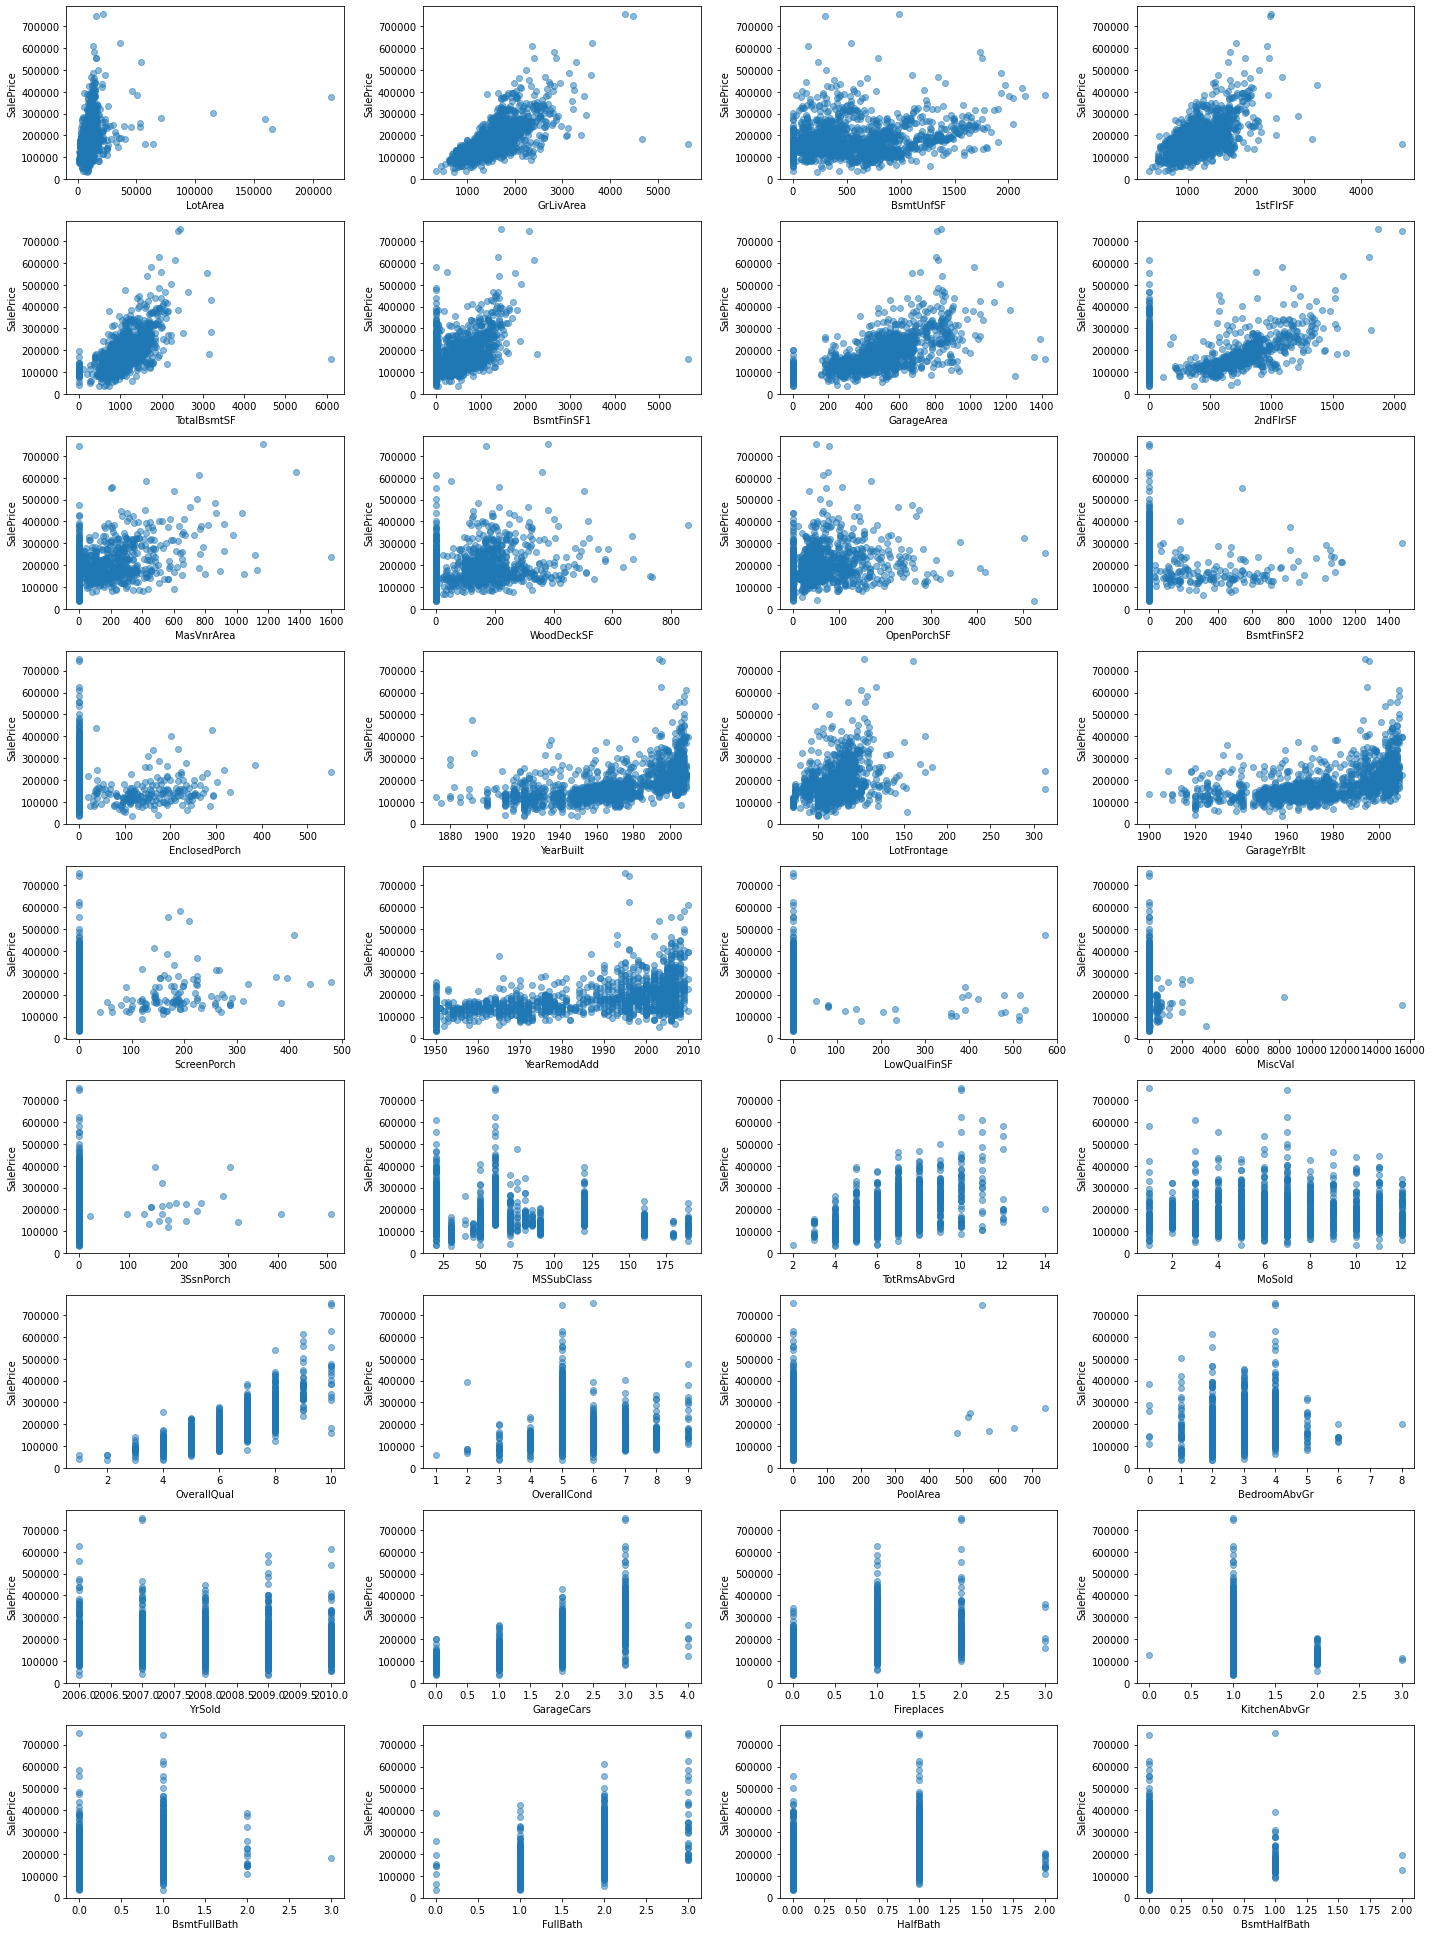

In [15]:
num_features = X_train.select_dtypes(include=[np.number]).columns

sorted_num_features = num_unique_counts.index

# Scatter plots for each numerical feature vs SalePrice
n_cols = 4
n_rows = (len(sorted_num_features) + n_cols - 1) // n_cols

plt.figure(figsize=(20, n_rows * 3))

for i, feature in enumerate(sorted_num_features, 1):
    plt.subplot(n_rows, n_cols, i)
    plt.scatter(X_train[feature], y_train, alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel("SalePrice")
    plt.tight_layout()

plt.show()

### Feature Treatment Overview (Numerical / Integer Features)

| Feature             | Unique Values | Suggested Treatment                  | Notes |
|--------------------|---------------|------------------------------------|-------|
| LotArea             | 1073          | Continuous                          | High range, treat as numeric, scaling/log optional |
| GrLivArea           | 861           | Continuous                          | As above |
| BsmtUnfSF           | 780           | Continuous                          | As above |
| 1stFlrSF            | 753           | Continuous                          | As above |
| TotalBsmtSF         | 721           | Continuous                          | As above |
| BsmtFinSF1          | 637           | Continuous                          | As above |
| GarageArea          | 441           | Continuous                          | As above |
| 2ndFlrSF            | 417           | Continuous                          | As above |
| MasVnrArea          | 327           | Continuous                          | As above |
| WoodDeckSF          | 274           | Continuous                          | As above |
| OpenPorchSF         | 202           | Continuous                          | As above |
| BsmtFinSF2          | 144           | Continuous                          | As above |
| EnclosedPorch       | 120           | Continuous                          | As above |
| YearBuilt           | 112           | Continuous                          | As above |
| LotFrontage         | 110           | Continuous                          | As above |
| GarageYrBlt          | 97           | Continuous                          | As above |
| ScreenPorch          | 76           | Continuous                          | As above |
| YearRemodAdd         | 61           | Continuous                          | As above |

#### Borderline / Sparse Numerical Features (mostly zeros)
| Feature             | Unique Values | Suggested Treatment                  | Notes |
|--------------------|---------------|------------------------------------|-------|
| LowQualFinSF        | 24            | Binary indicator                     | 0 = none, >0 = has low-quality finished SF |
| MiscVal             | 21            | Binary indicator                     | 0 = no misc feature, >0 = has misc feature |
| 3SsnPorch           | 20            | Binary indicator                     | 0 = no porch, >0 = has porch |
| PoolArea            | 8             | Binary indicator                     | 0 = no pool, >0 = has pool |

#### Integer Features to Treat as Categorical
| Feature             | Unique Values | Suggested Treatment                | Notes |
|---------------------|---------------|------------------------------------|-------|
| MSSubClass          | 15            | Categorical (one-hot)              | Building type codes |
| TotRmsAbvGrd        | 12            | Categorical / ordinal              | Count |
| MoSold              | 12            | Categorical (one-hot)              | Month sold |
| OverallQual         | 10            | Ordinal                            | 1–10 rating |
| OverallCond         | 9             | Ordinal                            | 1–10 rating |
| BedroomAbvGr        | 8             | Ordinal / categorical              | Count |
| YrSold              | 5             | Categorical (one-hot)              | Year sold |
| GarageCars          | 5             | Ordinal / categorical              | Count |
| Fireplaces          | 4             | Ordinal / categorical              | Count |
| KitchenAbvGr        | 4             | Ordinal / categorical              | Count |
| BsmtFullBath        | 4             | Ordinal / categorical              | Count |
| FullBath            | 4             | Ordinal / categorical              | Count |
| HalfBath            | 3             | Ordinal / categorical              | Count |
| BsmtHalfBath        | 3             | Ordinal / categorical              | Count |

In [16]:
# Feature groups dictionary
feature_groups = {
    "continuous": [
        "LotArea", "GrLivArea", "BsmtUnfSF", "1stFlrSF", "TotalBsmtSF",
        "BsmtFinSF1", "GarageArea", "2ndFlrSF", "MasVnrArea",
        "WoodDeckSF", "OpenPorchSF", "BsmtFinSF2", "EnclosedPorch",
        "YearBuilt", "LotFrontage", "GarageYrBlt", "ScreenPorch", "YearRemodAdd"
    ],
    "borderline_binary": ["LowQualFinSF", "MiscVal", "3SsnPorch", "PoolArea"],
    "integer_categorical": [
        "MSSubClass", "TotRmsAbvGrd", "MoSold", "OverallQual", "OverallCond",
        "BedroomAbvGr", "YrSold", "GarageCars", "Fireplaces",
        "KitchenAbvGr", "BsmtFullBath", "FullBath", "HalfBath", "BsmtHalfBath"
    ]
}

# Also create flat lists for each group
continuous_features = feature_groups["continuous"]
borderline_binary_features = feature_groups["borderline_binary"]
integer_categorical_features = feature_groups["integer_categorical"]

In [17]:
# Convert sparse/borderline features into binary flags, preserving NaNs
for col in borderline_binary_features:
    X_train[f"{col}_flag"] = X_train[col].notna() & (X_train[col] > 0)
    X_train[f"{col}_flag"] = X_train[f"{col}_flag"].astype(str)
    
    X_test[f"{col}_flag"] = X_test[col].notna() & (X_test[col] > 0)
    X_test[f"{col}_flag"] = X_test[f"{col}_flag"].astype(str)
    
X_train.drop(columns=borderline_binary_features, inplace=True)
X_test.drop(columns=borderline_binary_features, inplace=True)

In [18]:
# Convert continuous integer features to float
X_train[continuous_features] = X_train[continuous_features].astype(float)
X_test[continuous_features] = X_test[continuous_features].astype(float)

# Convert integer categorical features to string/object for encoding later
for col in integer_categorical_features:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)
    
# Ensure existing object/text categorical features are also string
text_categorical_features = X_train.select_dtypes(include=["object"]).columns
for col in text_categorical_features:
    X_train[col] = X_train[col].astype("string")
    X_test[col] = X_test[col].astype("string")

**Summary**:

- We inspected all numerical features using unique value counts and scatterplots against `SalePrice`.  
- Features were then manually grouped into three categories:  
  - **Continuous** (true numeric measures, suitable for scaling/log transforms).  
  - **Borderline sparse/binary** (mostly zeros, recast into indicator variables).  
  - **Integer categorical** (discrete counts or codes, treated as categorical/ordinal).  
- Using this classification, we standardized data types:  
  - Continuous features converted to `float`.  
  - Binary flags created for sparse numerical fields.  
  - Integer categorical features cast to `string` for later encoding.  
  - Existing text categories normalized as `string`.  

This ensures that each variable is represented consistently and prepared for the next preprocessing steps (missing values, encoding, scaling).  

### 3.2 Outlier Detection

Outlier detection is an important step before modeling, but it needs to be handled carefully in this dataset.  
Many continuous features (e.g., `BsmtFinSF2`, `PoolArea`, `3SsnPorch`) have a **large mass at zero** with a long right tail.  
If we apply standard transformations or outlier detection directly, these zeros can distort results.  
To address this, we adopt a **two-step approach**:

---

**Step 1: Skewness check and log-transformation**:
- We first compute skewness for all continuous features.  
- Features with **skew > 0.75** are log-transformed.  
- Since many features have zeros, we apply `log1p(x)` **only to positive values**, leaving zeros untouched.  
  - This preserves the natural “spike” at zero while reducing skewness in the positive range.  

This transformation makes distributions more symmetric and prepares them for reliable outlier detection.

---

**Step 2: Outlier detection using Z-scores**:
- For each transformed feature, we compute **Z-scores** (standardized values).  
- Observations with `|Z| > 3` are flagged as potential outliers.  
- To avoid false positives from the spike at zero, Z-scores are calculated **only on positive values**.  

---

**Handling strategy**:
- If only a few rows are flagged → we remove them from the training set.  
- If many rows are flagged for a feature → we prefer transformation rather than deletion (already addressed by log-transform).  

This balances **robustness** (mitigating extreme values) with **data preservation** (avoiding excessive row loss).

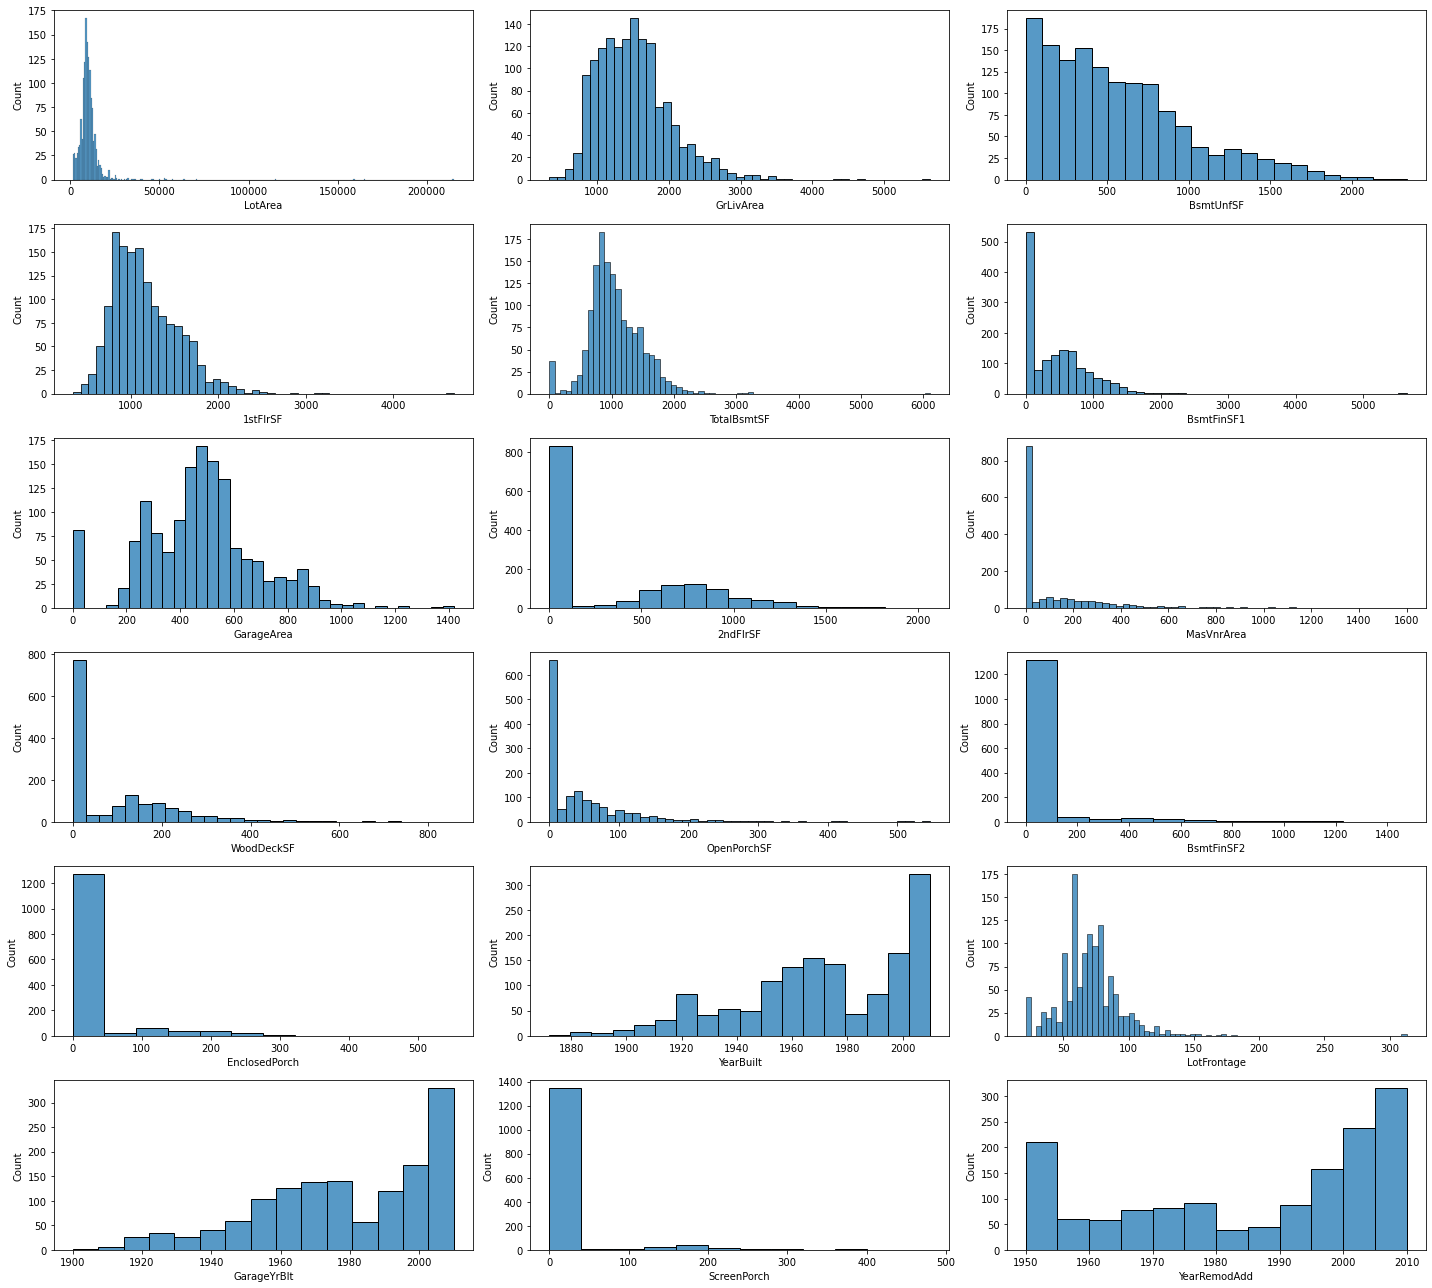

In [19]:
# Plot histograms for continuous features
n_cols = 3
n_rows = (len(continuous_features) + n_cols - 1) // n_cols

plt.figure(figsize=(20, n_rows * 3))

for i, feature in enumerate(continuous_features, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(X_train[feature])
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.tight_layout()

plt.show()

In [20]:
# Compute skewness
continuous_skewness = X_train[continuous_features].apply(lambda x: skew(x.dropna()))
skewed_continuous_features = continuous_skewness[continuous_skewness > 0.75].index

print(f"Float features to log-transform (skew > 0.75): {list(skewed_continuous_features)}")

# Apply log1p only to positive values, keep zeros as zero
for col in skewed_continuous_features:
    X_train[col] = X_train[col].apply(lambda x: np.log1p(x) if x > 0 else 0)
    X_test[col] = X_test[col].apply(lambda x: np.log1p(x) if x > 0 else 0)

Float features to log-transform (skew > 0.75): ['LotArea', 'GrLivArea', 'BsmtUnfSF', '1stFlrSF', 'TotalBsmtSF', 'BsmtFinSF1', '2ndFlrSF', 'MasVnrArea', 'WoodDeckSF', 'OpenPorchSF', 'BsmtFinSF2', 'EnclosedPorch', 'LotFrontage', 'ScreenPorch']


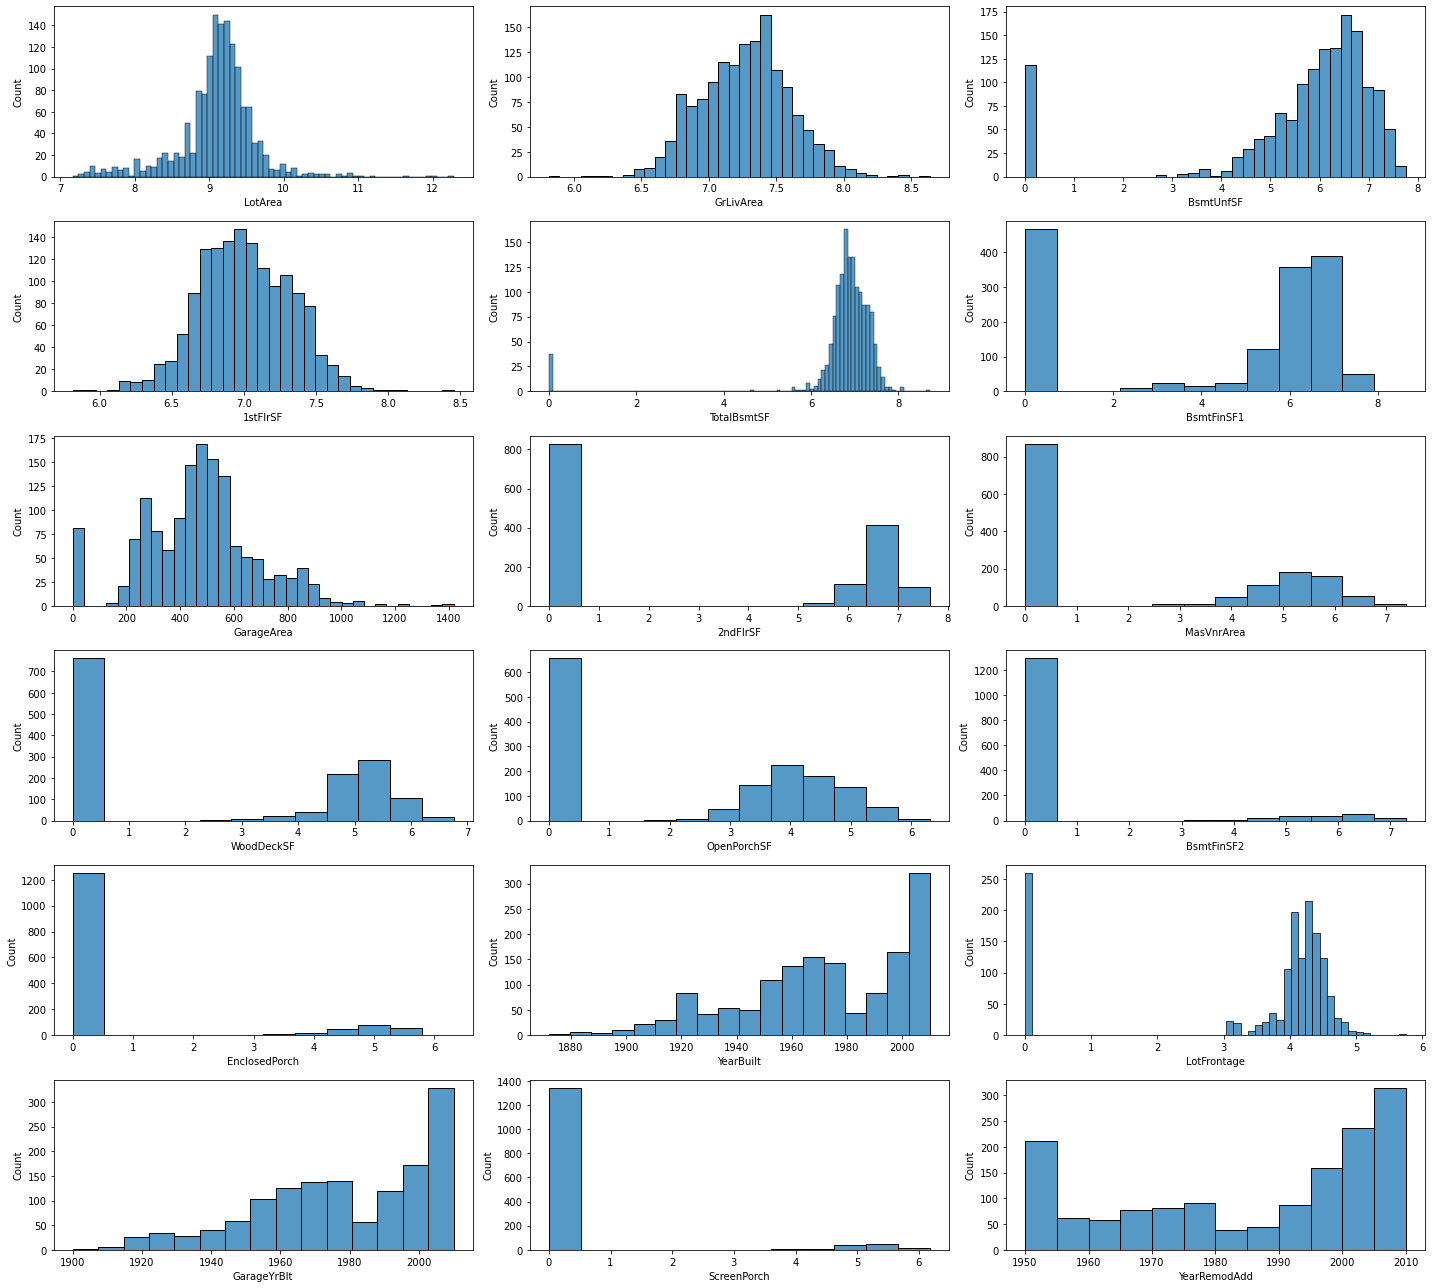

In [21]:
# Plot histograms for continuous features after log-transform

n_cols = 3
n_rows = (len(continuous_features) + n_cols - 1) // n_cols

plt.figure(figsize=(20, n_rows * 3))

for i, feature in enumerate(continuous_features, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(X_train[feature])
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.tight_layout()

plt.show()

In [22]:
outlier_summary = []

for col in continuous_features:
    if col in X_train.columns:
        # Consider only positive values (ignore zeros) and drop NaNs
        pos_values = X_train.loc[X_train[col] > 0, col].dropna()
        if len(pos_values) == 0:
            continue  # skip if no positive values
        
        # Compute Z-scores
        z_scores = np.abs(stats.zscore(pos_values))
        
        # Count outliers (Z > 3)
        count_outliers = (z_scores > 3).sum()
        
        # Percentage relative to positive entries
        perc_outliers = 100 * count_outliers / len(pos_values)
        
        outlier_summary.append((col, count_outliers, perc_outliers))

# Convert to DataFrame and sort by percentage
outlier_summary = pd.DataFrame(outlier_summary, columns=["Feature", "Outlier_Count", "Outlier_%"])
outlier_summary.sort_values(by="Outlier_%", ascending=False, inplace=True)

display(outlier_summary)

,Feature,Outlier_Count,Outlier_%
5,BsmtFinSF1,33,3.323263
0,LotArea,33,2.260274
14,LotFrontage,25,2.081599
7,2ndFlrSF,9,1.426307
9,WoodDeckSF,8,1.144492
2,BsmtUnfSF,14,1.043219
12,EnclosedPorch,2,0.961538
4,TotalBsmtSF,13,0.913563
16,ScreenPorch,1,0.862069
6,GarageArea,8,0.580131


In [23]:
# Initialize mask for all outliers
outlier_mask = pd.Series(False, index=X_train.index)

for col in continuous_features:
    if col in X_train.columns:
        # Only positive values for Z-score
        pos_values = X_train.loc[X_train[col] > 0, col]
        if len(pos_values) == 0:
            continue  # skip if no positive values
        
        # Compute Z-scores
        z_scores = stats.zscore(pos_values)
        
        # Create mask for outliers and reindex to original DataFrame, fill NaNs with False
        mask = pd.Series(z_scores, index=pos_values.index).abs() > 3
        mask = mask.reindex(X_train.index, fill_value=False)
        
        # Update global outlier mask
        outlier_mask |= mask

print(f"Rows before: {X_train.shape[0]}")
print(f"Rows flagged as outliers: {outlier_mask.sum()}")
print(f"Rows after dropping: {X_train.shape[0] - outlier_mask.sum()}")

# Drop rows from both X and y
X_train_clean = X_train.loc[~outlier_mask].copy()
y_train_clean = y_train.loc[~outlier_mask].copy()

Rows before: 1460
Rows flagged as outliers: 137
Rows after dropping: 1323


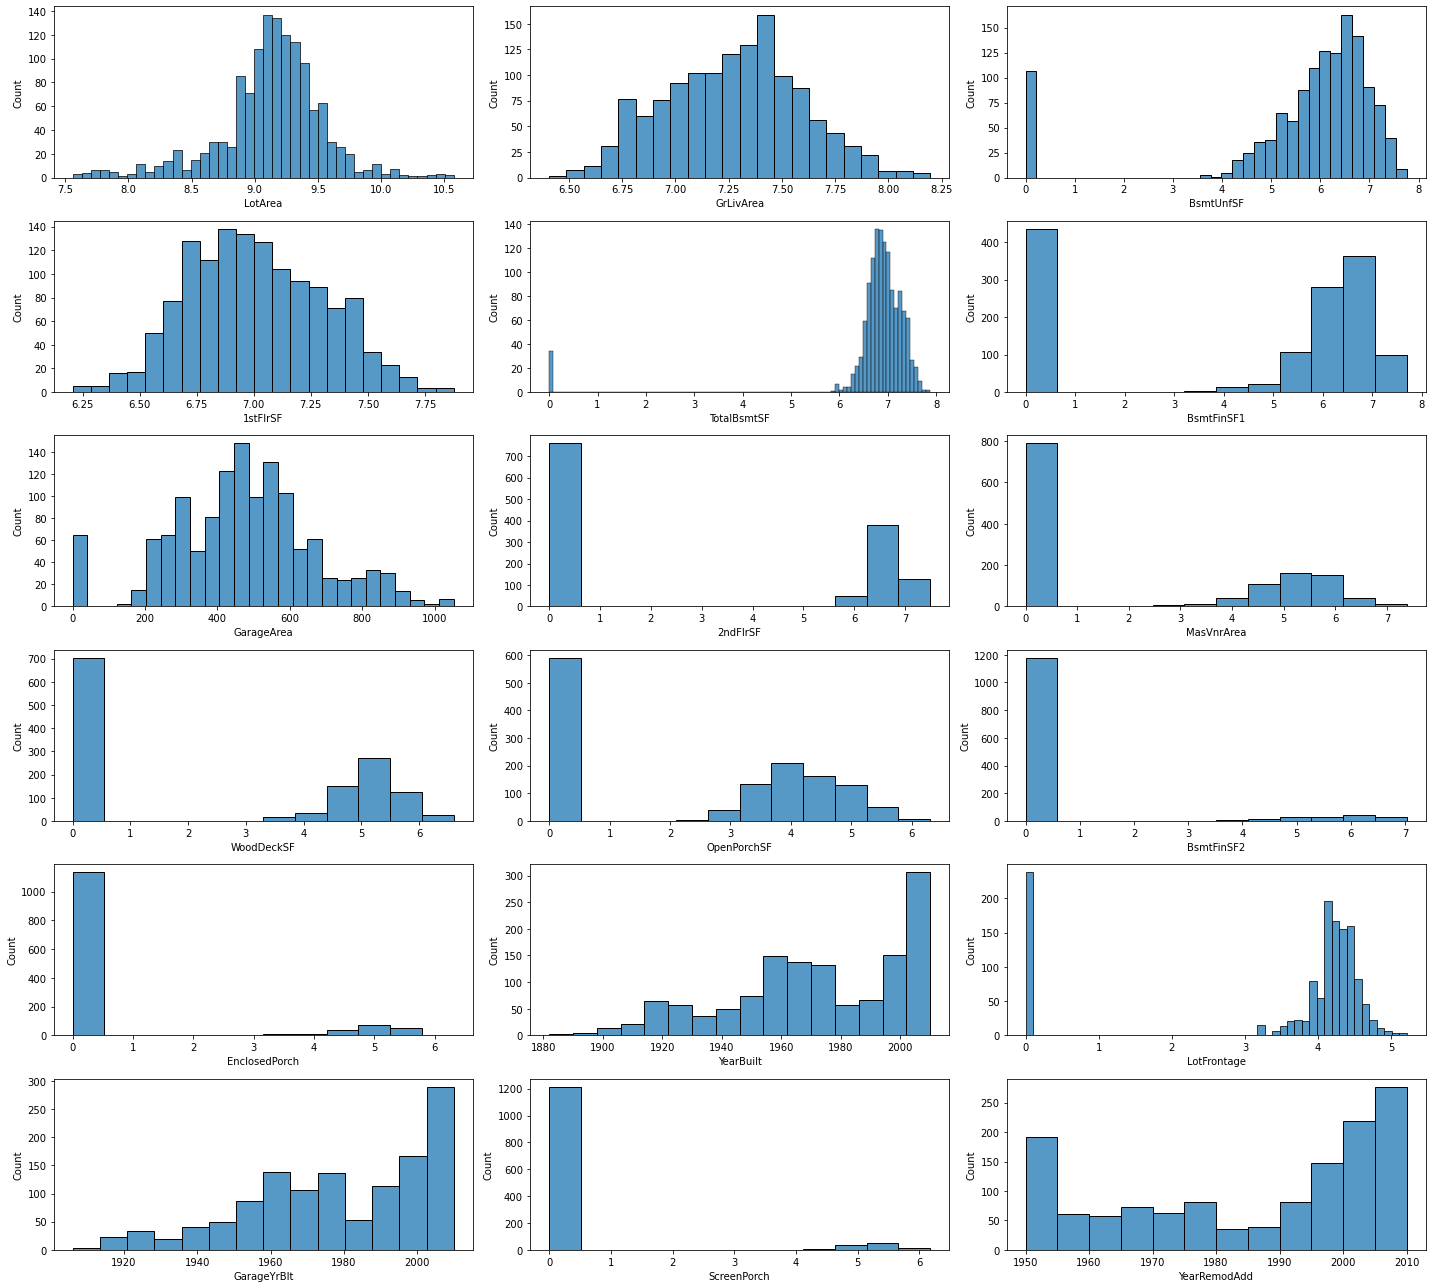

In [24]:
# Plot histograms for continuous features after log-transform and cleaning outliers

n_cols = 3
n_rows = (len(continuous_features) + n_cols - 1) // n_cols

plt.figure(figsize=(20, n_rows * 3))

for i, feature in enumerate(continuous_features, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(X_train_clean[feature])
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.tight_layout()

plt.show()

**Results**:
- Continuous features became much closer to normal distributions after log-transform.  
- 137 rows were flagged as outliers across multiple features.  
- Final cleaned training set size: **1323 rows** (from 1460 originally).  

---

### Key notes
- **Tree-based models** (Random Forest, XGBoost) are generally robust to skewness and zeros, but benefit from removing extreme anomalies.  
- **Linear and regularized regression models** are more sensitive to distributional shape, so the log-transform and outlier removal are particularly important for them.  
- Features with strong zero-mass could later be split into:  
  - **binary indicator** (presence/absence), plus  
  - **continuous value** (size if >0).  
  This is optional and can be tested in model tuning.

### 3.3 Unified Preprocessing: Missing Values, Encoding, and Scaling

Instead of handling missing values, encoding, and scaling separately, we design a **unified preprocessing pipeline** that ensures consistent, reproducible transformations across both training and test data. This pipeline takes into account the different types of features in the dataset:

---

1. **Handling Missing Values**:
- **Categorical features with true absence** (e.g., `PoolQC`, `Alley`, `Fence`, `FireplaceQu`)  
  → Missing values are replaced with `"None"` to explicitly represent the absence of the feature. Using the **most frequent category** instead would incorrectly suggest that the house has the feature, potentially misleading the model.  
- **Other categorical features** → Missing values are imputed with the **most frequent category**, preserving interpretability.  
- **Numerical features** → Missing values are imputed with the **median**, which is robust to skewed distributions.  

---

2. **Encoding Categorical Variables**:
- **Ordinal categorical features** (e.g., `OverallQual`, `OverallCond`):  
  Encoded with an **ordinal mapping** using `OrdinalEncoder`, reflecting their natural ranking.  
- **Nominal categorical features** (e.g., `MSSubClass`, `Neighborhood`):  
  Encoded with **one-hot encoding**, avoiding artificial ordering.  
- **Other string-based features**:  
  Also encoded with one-hot to maintain flexibility.  

    This combination allows the model to distinguish between ordered quality scores and purely categorical labels.

---

3. **Scaling Numerical Features**:
- Continuous numerical features are standardized using **z-score scaling** (`StandardScaler`).  
- This ensures that models sensitive to feature magnitude (e.g., linear regression, regularized models, neural nets) do not overweight variables with larger raw scales.  

    Tree-based models are scale-invariant, but keeping the scaling step ensures consistency across all candidate models.

---

4. **Pipeline Implementation**:

    All steps are combined into a **scikit-learn `ColumnTransformer`** with dedicated pipelines for each feature type:
- **Numerical pipeline**: median imputation + scaling  
- **Ordinal pipeline**: most frequent imputation + ordinal encoding  
- **Nominal pipelines**: most frequent imputation + one-hot encoding  
- **Absence-encoded categorical pipeline**: string conversion + fill with `"None"` + one-hot encoding  

    By integrating everything into a single pipeline, we guarantee:
    
    
- Identical transformations on train and test sets  
- Clean modular structure that avoids leakage  
- Easy extension if new preprocessing steps are required later  

---

**Result**:

After applying the pipeline:
- Training set (`X_train_processed`) and test set (`X_test_processed`) are fully numeric, imputed, encoded, and scaled.  
- Shape of processed data reflects expansion from one-hot encoding.  
- The dataset is now ready for **feature selection** and **modeling**.  

In [25]:
# Ordinal categorical features (have natural order, e.g. quality ratings)
ordinal_features = ["OverallQual", "OverallCond"]

# Nominal categorical features (unordered, best one-hot encoded)
onehot_features = [
    "MSSubClass", "TotRmsAbvGrd", "MoSold", "BedroomAbvGr", "YrSold",
    "GarageCars", "Fireplaces", "KitchenAbvGr", "BsmtFullBath",
    "FullBath", "HalfBath", "BsmtHalfBath"
]

categorical_features = X_train_clean.select_dtypes(include=['string']).columns.tolist()

# All other categorical features (strings like Neighborhood, Exterior, etc.)
other_categorical = [
    col for col in categorical_features 
    if col not in ordinal_features + onehot_features
]

# Fill missing with 'None' for other_categorical features
X_train_clean[other_categorical] = X_train_clean[other_categorical].fillna('None')
X_test[other_categorical] = X_test[other_categorical].fillna('None')
#X_test[other_cat_features] = X_test[other_cat_features].astype(str).fillna('None')

In [26]:
# Ordinal pipeline
ordinal_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# One-hot pipeline
onehot_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# "Other" categorical pipeline (still one-hot)
other_cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [27]:
# Numerical pipeline: median imputation + scaling
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [28]:
# Final preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, continuous_features),
    ('ord', ordinal_pipeline, ordinal_features),
    ('onehot', onehot_pipeline, onehot_features),
    ('othercat', other_cat_pipeline, other_categorical)
])

In [29]:
X_train_processed = preprocessor.fit_transform(X_train_clean)
X_test_processed = preprocessor.transform(X_test)

print("Train processed shape:", X_train_processed.shape)
print("Test processed shape:", X_test_processed.shape)

Train processed shape: (1323, 368)
Test processed shape: (1459, 368)


## 4. Baseline Models: Linear Regression, Ridge, and Lasso  

After preprocessing and feature engineering, we start building **baseline regression models** to establish reference performance.  
These models are simple yet powerful, providing a benchmark against which more complex approaches (tree-based models, ensembles) can later be compared.  

We focus on three classic linear models:  

- **Linear Regression**: Ordinary least squares regression, modeling a linear relationship between features and the target.  
- **Ridge Regression**: Linear regression with L2 regularization, which reduces variance by shrinking coefficients but keeps all predictors.  
- **Lasso Regression**: Linear regression with L1 regularization, which can also perform implicit feature selection by shrinking some coefficients to zero.  

**Evaluation setup**:  
- Target: `SalePrice`, log-transformed as `log1p(SalePrice)` to stabilize variance and reduce skew.  
- Metric: Root Mean Squared Error (**RMSE**) on the log scale, evaluated with 5-fold cross-validation.  
- Purpose: Establish **baseline generalization performance** and examine the effect of regularization.  

The results from this section serve as a **reference point**: if later models do not outperform these baselines, additional complexity may not be justified.  

In [30]:
# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0, random_state=42),
    "Lasso Regression": Lasso(alpha=0.01, random_state=42, max_iter=10000)
}

# RMSE scorer (on log1p scale)
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)))

# 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate each model
cv_results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train_processed, np.log1p(y_train_clean), 
                             scoring=rmse_scorer, cv=kf)
    cv_results[name] = scores
    print(f"{name} | Mean RMSE: {scores.mean():.4f} | Std: {scores.std():.4f}")

# Optional: convert to DataFrame for comparison
cv_df = pd.DataFrame(cv_results)
cv_df.T.rename(columns={i: f"Fold {i+1}" for i in range(cv_df.shape[1])})

Linear Regression | Mean RMSE: 2556879542.4846 | Std: 1922563773.8852
Ridge Regression | Mean RMSE: 0.1205 | Std: 0.0151
Lasso Regression | Mean RMSE: 0.1420 | Std: 0.0158


,Fold 1,Fold 2,Fold 3,3,4
Linear Regression,1.207410e+09,8.324216e+08,4.127749e+09,5.554428e+09,1.062389e+09
Ridge Regression,1.343549e-01,1.147693e-01,1.418914e-01,1.081227e-01,1.031767e-01
Lasso Regression,1.597349e-01,1.474718e-01,1.527303e-01,1.353419e-01,1.146673e-01


**Debugging Linear Regression Performance**:  

**Linear Regression shows unexpectedly high RMSE** compared to Ridge and Lasso.  
This raised the suspicion that the issue might not be with the model itself, but with the **feature preprocessing pipeline**, especially the way categorical variables were encoded.  

To investigate, we progressively built pipelines of increasing complexity:  

1. **Numerical only**  
2. **Numerical + Ordinal features**  
3. **Numerical + Ordinal + Small OneHot subset**  
4. **Numerical + Ordinal + Larger OneHot subset**  
5. **Full pipeline with all features**  

By evaluating Linear Regression at each stage, we can identify at which point performance deteriorates and confirm whether specific feature groups cause instability.

In [31]:
# --- Common CV setup ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# --- Define feature subsets ---
ordinal_features = ["OverallQual", "OverallCond"]

small_onehot_features = ["MSZoning"]   # start small
bigger_onehot_features = ["MSZoning", "Neighborhood"]   # add more later
#all_onehot_features = [
#    "TotRmsAbvGrd", "MoSold", "BedroomAbvGr", "YrSold",
#    "GarageCars", "Fireplaces", "KitchenAbvGr", "BsmtFullBath",
#    "FullBath", "HalfBath", "BsmtHalfBath", "MSSubClass", 
#    "MSZoning", "Neighborhood"
#]

all_onehot_features = onehot_features+other_categorical

# --- Pipelines ---
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

ord_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

onehot_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# --- Progressive tests ---
tests = {
    "Numerical only": ColumnTransformer([
        ("num", num_pipeline, continuous_features)
    ]),
    
    "Numerical + Ordinal": ColumnTransformer([
        ("num", num_pipeline, continuous_features),
        ("ord", ord_pipeline, ordinal_features)
    ]),
    
    "Numerical + Ordinal + Small OneHot": ColumnTransformer([
        ("num", num_pipeline, continuous_features),
        ("ord", ord_pipeline, ordinal_features),
        ("cat", onehot_pipeline, small_onehot_features)
    ]),
    
    "Numerical + Ordinal + Bigger OneHot": ColumnTransformer([
        ("num", num_pipeline, continuous_features),
        ("ord", ord_pipeline, ordinal_features),
        ("cat", onehot_pipeline, bigger_onehot_features)
    ]),
    
    "Full pipeline (all features)": ColumnTransformer([
        ("num", num_pipeline, continuous_features),
        ("ord", ord_pipeline, ordinal_features),
        ("cat", onehot_pipeline, all_onehot_features)
    ])
}

# --- Run tests ---
for name, preprocessor in tests.items():
    X_proc = preprocessor.fit_transform(X_train_clean)
    scores = cross_val_score(
        LinearRegression(),
        X_proc,
        np.log1p(y_train_clean),
        scoring="neg_root_mean_squared_error",
        cv=kf
    )
    rmse_scores = -scores  # convert back to positive RMSE
    print(f"{name} | Mean RMSE: {rmse_scores.mean():.4f} | Std: {rmse_scores.std():.4f}")

Numerical only | Mean RMSE: 0.1605 | Std: 0.0119
Numerical + Ordinal | Mean RMSE: 0.1451 | Std: 0.0138
Numerical + Ordinal + Small OneHot | Mean RMSE: 0.1431 | Std: 0.0104
Numerical + Ordinal + Bigger OneHot | Mean RMSE: 0.1303 | Std: 0.0123
Full pipeline (all features) | Mean RMSE: 2556879542.4846 | Std: 1922563773.8852


The experiment confirmed that **the instability in Linear Regression comes from the high-cardinality categorical features**.  
When restricted to numerical and ordinal variables, performance was stable. However, adding broader sets of one-hot encoded categories (especially features like `Neighborhood`) led to inflated RMSE. This is due to **multicollinearity** and the high dimensionality introduced by one-hot encoding.  

This is expected:  
- One-hot encoding creates a very sparse, high-dimensional design matrix.  
- Linear Regression without regularization struggles in this setting, leading to unstable coefficients and poor generalization.  
- Regularized models such as Ridge and Lasso handle this better, which explains their much lower RMSE in the earlier comparison.  

This diagnostic highlights the importance of **regularization** when dealing with wide, sparse feature spaces, and justifies Ridge and Lasso as stronger linear baselines.  

### 4.1 Hyperparameter Tuning: Ridge and Lasso

To improve the baseline linear models, we now perform hyperparameter tuning for **Ridge** and **Lasso** regressions. The key hyperparameter is `alpha`, which controls the strength of regularization:

- **Ridge**: L2 regularization, shrinks coefficients but does not set them exactly to zero.
- **Lasso**: L1 regularization, can shrink some coefficients to zero, effectively performing feature selection.

We will use **RandomizedSearchCV** for efficiency over GridSearchCV, especially when testing a wide range of alpha values.

In [32]:
# --- Full preprocessing pipeline ---
# Use your previous ColumnTransformer: preprocessor
# numerical + ordinal + one-hot encoding

# Ridge pipeline
ridge_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("model", Ridge())
])

# Lasso pipeline
lasso_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("model", Lasso(max_iter=10000))
])

# Hyperparameter distributions
param_distributions_ridge = {"model__alpha": np.logspace(-3, 3, 100)}
param_distributions_lasso = {"model__alpha": np.logspace(-3, 3, 100)}

# RandomizedSearchCV for Ridge
ridge_search = RandomizedSearchCV(
    ridge_pipeline,
    param_distributions=param_distributions_ridge,
    n_iter=20,
    scoring="neg_root_mean_squared_error",
    cv=5,
    random_state=42,
    n_jobs=-1
)

# RandomizedSearchCV for Lasso
lasso_search = RandomizedSearchCV(
    lasso_pipeline,
    param_distributions=param_distributions_lasso,
    n_iter=20,
    scoring="neg_root_mean_squared_error",
    cv=5,
    random_state=42,
    n_jobs=-1
)

# Fit
ridge_search.fit(X_train_clean, np.log1p(y_train_clean))
lasso_search.fit(X_train_clean, np.log1p(y_train_clean))

# Ridge
best_ridge_idx = ridge_search.best_index_
ridge_mean = ridge_search.cv_results_['mean_test_score'][best_ridge_idx]
ridge_std = ridge_search.cv_results_['std_test_score'][best_ridge_idx]

print(f"Best Ridge: {ridge_search.best_params_} | Mean RMSE: {-ridge_mean:.4f} | Std: {ridge_std:.4f}")

# Lasso
best_lasso_idx = lasso_search.best_index_
lasso_mean = lasso_search.cv_results_['mean_test_score'][best_lasso_idx]
lasso_std = lasso_search.cv_results_['std_test_score'][best_lasso_idx]

print(f"Best Lasso: {lasso_search.best_params_} | Mean RMSE: {-lasso_mean:.4f} | Std: {lasso_std:.4f}")

Best Ridge: {'model__alpha': 17.47528400007683} | Mean RMSE: 0.1182 | Std: 0.0044
Best Lasso: {'model__alpha': 0.001} | Mean RMSE: 0.1167 | Std: 0.0046


Hyperparameter tuning for Ridge and Lasso produces a measurable improvement over the default models. Even if the RMSE reduction is modest, it demonstrates that regularization strength matters and that careful tuning can help stabilize coefficient estimates and improve generalization.

**ADD FEATURES IMPORTANCE PLOT HERE (future)**

**Learning Curves for Tuned Ridge and Lasso**

To further assess the performance of our tuned models, we plot learning curves showing training and validation RMSE as a function of the training set size.

Observations:

- Both Ridge and Lasso show flattening validation error as the training size increases, indicating that adding more data would likely not drastically improve performance.

- Training and validation RMSE are relatively close, suggesting minimal overfitting.

- The curves confirm that the preprocessing and feature engineering pipeline is providing stable inputs for linear models.

These plots give confidence that the tuned regularized models are generalizing well and that the current dataset size is adequate for linear regression baselines.

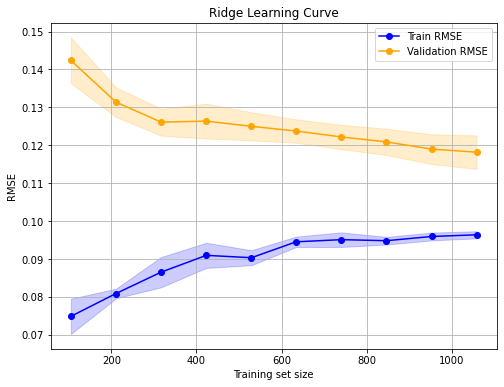

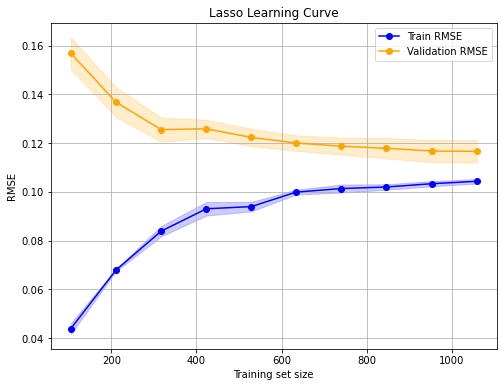

In [33]:
def plot_learning_curve(model, X, y, title="Learning Curve", cv=5):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=cv, scoring='neg_root_mean_squared_error',
        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
    )
    
    # Convert scores to positive RMSE
    train_rmse = -train_scores
    val_rmse = -val_scores
    
    plt.figure(figsize=(8,6))
    plt.plot(train_sizes, train_rmse.mean(axis=1), 'o-', color='blue', label="Train RMSE")
    plt.fill_between(train_sizes,
                     train_rmse.mean(axis=1) - train_rmse.std(axis=1),
                     train_rmse.mean(axis=1) + train_rmse.std(axis=1),
                     color='blue', alpha=0.2)
    
    plt.plot(train_sizes, val_rmse.mean(axis=1), 'o-', color='orange', label="Validation RMSE")
    plt.fill_between(train_sizes,
                     val_rmse.mean(axis=1) - val_rmse.std(axis=1),
                     val_rmse.mean(axis=1) + val_rmse.std(axis=1),
                     color='orange', alpha=0.2)
    
    plt.title(title)
    plt.xlabel("Training set size")
    plt.ylabel("RMSE")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

# Make sure to use the processed pipeline for X_train_clean
X_proc = preprocessor.fit_transform(X_train_clean)
y_log = np.log1p(y_train_clean)

plot_learning_curve(Ridge(alpha=ridge_search.best_params_['model__alpha']),
                    X_proc, y_log, title="Ridge Learning Curve")

plot_learning_curve(Lasso(alpha=lasso_search.best_params_['model__alpha']),
                    X_proc, y_log, title="Lasso Learning Curve")

**Residual Analysis for Lasso Regression**:

To assess model fit and identify potential patterns not captured by the model, we examine the **residuals** of the tuned Lasso regression:

- **Log-space residuals**: Differences between `log1p(SalePrice)` and predicted values, useful to evaluate model performance on the transformed target.  
- **Dollar-space residuals**: Differences in the original scale of `SalePrice`, which are more interpretable in real-world terms.

The four plots include:

1. Histogram of residuals (log-space): checks symmetry and potential bias.  
2. Residuals vs predicted values (log-space): looks for heteroscedasticity or trends.  
3. Residuals vs predicted values (original dollar): identifies systematic over- or under-prediction for expensive houses.  
4. Histogram of residuals (original dollar): shows distribution and scale of errors in dollars.

**Observations:**  

- Residuals are roughly symmetric in both log-space and dollar-space, indicating that the Lasso model is not systematically biased.  
- Residuals vs predicted plots show no strong trends or heteroscedasticity, suggesting errors are fairly consistent across predicted values.  
- Overall, the tuned Lasso provides a stable fit, slightly better than Ridge, and residuals appear well-behaved for further modeling.

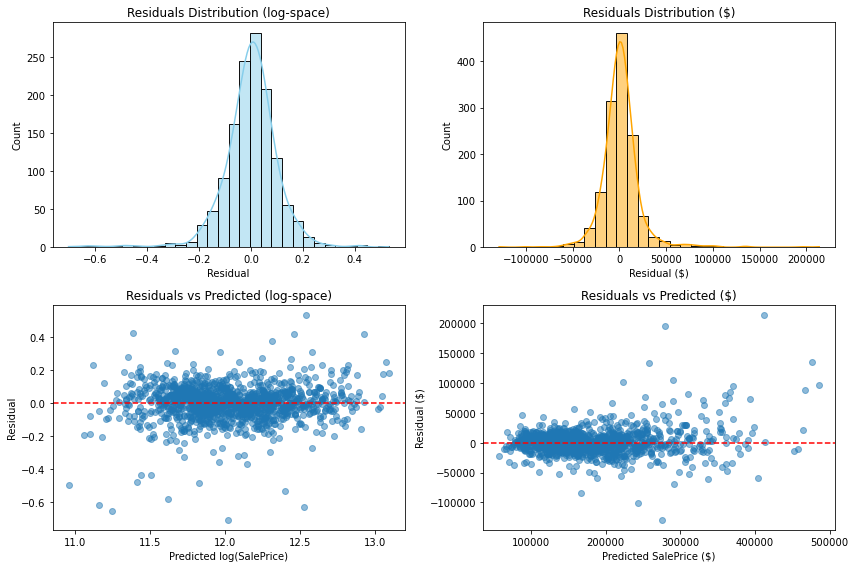

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Get the tuned and fitted Lasso model
lasso_model = lasso_search.best_estimator_

# Use the tuned Lasso model for prediction
y_pred_log_lasso = lasso_model.predict(X_train_clean)  # in log1p space
y_true_log = np.log1p(y_train_clean)

# Residuals in log-space
residuals_log_lasso = y_true_log - y_pred_log_lasso

# Residuals in dollar space
y_pred_dollar_lasso = np.expm1(y_pred_log_lasso)
residuals_dollar_lasso = y_train_clean - y_pred_dollar_lasso

# Residual histogram (log-space)
sns.histplot(residuals_log_lasso, bins=30, kde=True, color='skyblue', ax=axes[0,0])
axes[0,0].set_title("Residuals Distribution (log-space)")
axes[0,0].set_xlabel("Residual")
axes[0,0].set_ylabel("Count")

# Residual histogram (dollar-space)
sns.histplot(residuals_dollar_lasso, bins=30, kde=True, color='orange', ax=axes[0,1])
axes[0,1].set_title("Residuals Distribution ($)")
axes[0,1].set_xlabel("Residual ($)")
axes[0,1].set_ylabel("Count")

# Residuals vs predicted (log-space)
axes[1,0].scatter(y_pred_log_lasso, residuals_log_lasso, alpha=0.5)
axes[1,0].axhline(0, color='red', linestyle='--')
axes[1,0].set_title("Residuals vs Predicted (log-space)")
axes[1,0].set_xlabel("Predicted log(SalePrice)")
axes[1,0].set_ylabel("Residual")

# Residuals vs predicted (dollar-space)
axes[1,1].scatter(y_pred_dollar_lasso, residuals_dollar_lasso, alpha=0.5)
axes[1,1].axhline(0, color='red', linestyle='--')
axes[1,1].set_title("Residuals vs Predicted ($)")
axes[1,1].set_xlabel("Predicted SalePrice ($)")
axes[1,1].set_ylabel("Residual ($)")

plt.tight_layout()
plt.show()

## 5. Decision Tree, Random Forest & XGBoost

Decision tree-based models can capture non-linear relationships and interactions between features that linear models may miss. In this section, we start with a Decision Tree Regressor as a baseline, evaluate its performance using cross-validation, and compare it to our previous linear models (Ridge and Lasso). Later, we will extend to Random Forest and XGBoost for more robust ensemble predictions.

### 5.1 Baseline Decision Tree

We begin with a **Decision Tree Regressor** using default parameters as a baseline.  
Decision Trees can naturally capture **non-linear relationships** and **feature interactions**, but a default tree often overfits or underfits depending on the dataset. Therefore, the baseline result provides a reference point for later tuned and ensemble models.

In [35]:
# Use same CV setup as before
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Baseline Decision Tree (default parameters)
tree_model = DecisionTreeRegressor(random_state=42)

# Evaluate using RMSE scorer
scores_tree = cross_val_score(
    tree_model,
    X_train_processed,  # already preprocessed features
    np.log1p(y_train_clean),
    scoring='neg_root_mean_squared_error',
    cv=kf
)

print(f"Decision Tree | Mean RMSE: {-scores_tree.mean():.4f} | Std: {scores_tree.std():.4f}")

Decision Tree | Mean RMSE: 0.1984 | Std: 0.0161


**Hyperparameter Tuning for Decision Trees**:

To improve performance, we perform **RandomizedSearchCV** over key hyperparameters:  

- `max_depth`: limits tree depth to control overfitting.  
- `min_samples_split` & `min_samples_leaf`: ensure nodes have enough data to generalize.  
- `max_features`: controls the number of features considered at each split.  

This search identifies the best trade-off between model complexity and generalization.  
After tuning, we re-evaluate the model using cross-validation to confirm improvements over the baseline.

In [36]:
# Parameters to tune
param_dist = {
    "max_depth": [None, 5, 10, 15, 20, 25],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 4, 8],
    "max_features": [None, 'sqrt', 'log2']
}

tree_model = DecisionTreeRegressor(random_state=42)

tree_search = RandomizedSearchCV(
    tree_model,
    param_distributions=param_dist,
    n_iter=50,
    scoring='neg_root_mean_squared_error',
    cv=kf,
    random_state=42,
    n_jobs=-1
)

tree_search.fit(X_train_processed, np.log1p(y_train_clean))

print("Best Tree:", tree_search.best_params_)
print("Best RMSE:", -tree_search.best_score_)

Best Tree: {'min_samples_split': 20, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 15}
Best RMSE: 0.17689644002824548


In [37]:
# Best decision tree model after tuning

best_tree = tree_search.best_estimator_

scores_tree = cross_val_score(
    best_tree,
    X_train_processed,
    np.log1p(y_train_clean),
    scoring='neg_root_mean_squared_error',
    cv=kf
)

print(f"Tuned Decision Tree | Mean RMSE: {-scores_tree.mean():.4f} | Std: {scores_tree.std():.4f}")

Tuned Decision Tree | Mean RMSE: 0.1769 | Std: 0.0116


**Conclusion: Decision Tree Performance**

Even after hyperparameter tuning, the **Decision Tree** achieves a cross-validated RMSE of about **~0.17**, which is notably worse than the **Lasso baseline (~0.11 RMSE)**.  

This confirms that while a single decision tree can capture non-linearities, it lacks the robustness and generalization ability required for this dataset.  

**Next step:** We move to **ensemble tree methods** - starting with **Random Forests**, which combine many decision trees to reduce variance, and then to **XGBoost**, a boosting method that often achieves state-of-the-art results in tabular prediction tasks.

### 5.2 Random Forest

To improve on the weak performance of a single Decision Tree, we now use a **Random Forest**, which combines the predictions of many decision trees trained on different feature subsets and data samples. This ensemble approach helps reduce variance and improves generalization.  

We first train and cross-validate a **baseline Random Forest** with default hyperparameters.  

In [38]:
# --- CV setup ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Baseline Random Forest
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

# Cross-validation on baseline RF
scores_rf = cross_val_score(
    rf_model,
    X_train_processed,  # already preprocessed
    np.log1p(y_train_clean),
    scoring='neg_root_mean_squared_error',
    cv=kf
)

print(f"Random Forest | Mean RMSE: {-scores_rf.mean():.4f} | Std: {scores_rf.std():.4f}")

Random Forest | Mean RMSE: 0.1349 | Std: 0.0150


Next, we perform **hyperparameter tuning** with RandomizedSearchCV to optimize key parameters (`n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`, and `max_features`).  

The goal is to further improve predictive accuracy by balancing the depth and number of trees with the regularization of splits and feature selection.  

In [39]:
param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [1.0, 'sqrt', 'log2']
}

#'max_features': ['auto', 'sqrt', 'log2']
rf_search = RandomizedSearchCV(
    rf_model,
    param_distributions=param_dist,
    n_iter=50,
    scoring='neg_root_mean_squared_error',
    cv=kf,
    random_state=42,
    n_jobs=-1
)

rf_search.fit(X_train_processed, np.log1p(y_train_clean))

best_rf = rf_search.best_estimator_
print("Best RF params:", rf_search.best_params_)
print("Best RF CV RMSE:", -rf_search.best_score_)

Best RF params: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 1.0, 'max_depth': 20}
Best RF CV RMSE: 0.13482941366055803


In [40]:
# Best Random Forest model after tuning
best_rf = rf_search.best_estimator_

scores_rf_tuned = cross_val_score(
    best_rf,
    X_train_processed,
    np.log1p(y_train_clean),
    scoring='neg_root_mean_squared_error',
    cv=kf,
    n_jobs=-1
)

print(f"Tuned Random Forest | Mean RMSE: {-scores_rf_tuned.mean():.4f} | Std: {scores_rf_tuned.std():.4f}")

Tuned Random Forest | Mean RMSE: 0.1348 | Std: 0.0157


The tuned **Random Forest** achieves a mean CV RMSE of **0.1348 (±0.0157)**, which is higher than the best **Lasso** model (**0.1167 ± 0.0046**).  

This suggests that, despite capturing non-linearities, Random Forest underperforms compared to Lasso in this dataset.  
Lasso not only achieves lower error but also shows more stability (lower variance across folds).  

**Residual Analysis – Random Forest**:

To better understand the performance of the tuned Random Forest, we inspect residuals in both log-space and the original dollar-space.

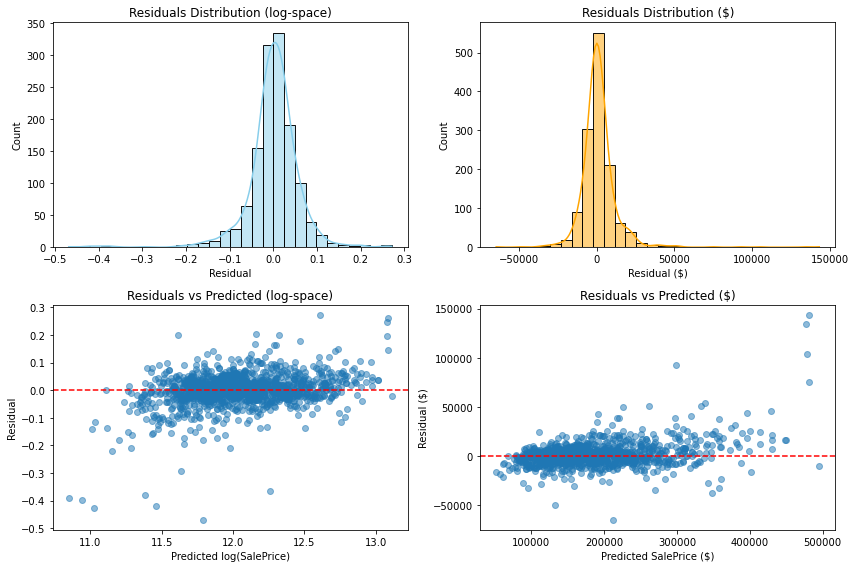

In [41]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Predictions with the best Random Forest model
y_pred_log_rf = best_rf.predict(X_train_processed)  # predictions in log1p space
y_true_log = np.log1p(y_train_clean)

# Residuals in log-space
residuals_log_rf = y_true_log - y_pred_log_rf

# --- Residuals in dollar space ---
y_pred_dollar_rf = np.expm1(y_pred_log_rf)
residuals_dollar_rf = y_train_clean - y_pred_dollar_rf

# Residual histogram (log-space)
sns.histplot(residuals_log_rf, bins=30, kde=True, color='skyblue', ax=axes[0,0])
axes[0,0].set_title("Residuals Distribution (log-space)")
axes[0,0].set_xlabel("Residual")
axes[0,0].set_ylabel("Count")

# Residual histogram (dollar-space)
sns.histplot(residuals_dollar_rf, bins=30, kde=True, color='orange', ax=axes[0,1])
axes[0,1].set_title("Residuals Distribution ($)")
axes[0,1].set_xlabel("Residual ($)")
axes[0,1].set_ylabel("Count")

# Residuals vs predicted (log-space)
axes[1,0].scatter(y_pred_log_rf, residuals_log_rf, alpha=0.5)
axes[1,0].axhline(0, color='red', linestyle='--')
axes[1,0].set_title("Residuals vs Predicted (log-space)")
axes[1,0].set_xlabel("Predicted log(SalePrice)")
axes[1,0].set_ylabel("Residual")

# Residuals vs predicted (dollar-space)
axes[1,1].scatter(y_pred_dollar_rf, residuals_dollar_rf, alpha=0.5)
axes[1,1].axhline(0, color='red', linestyle='--')
axes[1,1].set_title("Residuals vs Predicted ($)")
axes[1,1].set_xlabel("Predicted SalePrice ($)")
axes[1,1].set_ylabel("Residual ($)")

plt.tight_layout()
plt.show()

**Residuals comparison (best) Lasso vs (best) Random forest**

Comparing both models in residual space provides valuable insights into their different error structures and potential trade-offs.

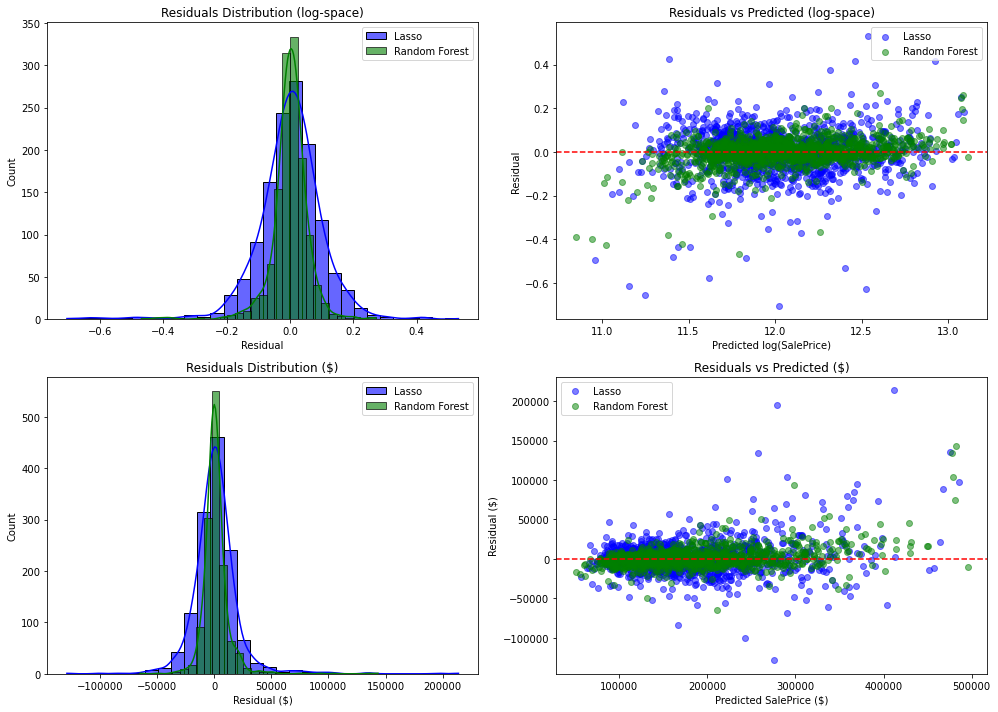

In [42]:
# --- Residuals in log-space ---
residuals_log_lasso = np.log1p(y_train_clean) - y_pred_log_lasso
residuals_log_rf    = np.log1p(y_train_clean) - y_pred_log_rf

# --- Residuals in dollar-space ---
y_pred_dollar_lasso = np.expm1(y_pred_log_lasso)
residuals_dollar_lasso = y_train_clean - y_pred_dollar_lasso

y_pred_dollar_rf = np.expm1(y_pred_log_rf)
residuals_dollar_rf = y_train_clean - y_pred_dollar_rf

# --- Plot ---
plt.figure(figsize=(14,10))

# 1. Histogram - log-space
plt.subplot(2,2,1)
sns.histplot(residuals_log_lasso, bins=30, kde=True, color='blue', label='Lasso', alpha=0.6)
sns.histplot(residuals_log_rf, bins=30, kde=True, color='green', label='Random Forest', alpha=0.6)
plt.title("Residuals Distribution (log-space)")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.legend()

# 2. Residuals vs Predicted - log-space
plt.subplot(2,2,2)
plt.scatter(y_pred_log_lasso, residuals_log_lasso, alpha=0.5, label='Lasso', color='blue')
plt.scatter(y_pred_log_rf, residuals_log_rf, alpha=0.5, label='Random Forest', color='green')
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted (log-space)")
plt.xlabel("Predicted log(SalePrice)")
plt.ylabel("Residual")
plt.legend()

# 3. Histogram - dollar-space
plt.subplot(2,2,3)
sns.histplot(residuals_dollar_lasso, bins=30, kde=True, color='blue', label='Lasso', alpha=0.6)
sns.histplot(residuals_dollar_rf, bins=30, kde=True, color='green', label='Random Forest', alpha=0.6)
plt.title("Residuals Distribution ($)")
plt.xlabel("Residual ($)")
plt.ylabel("Count")
plt.legend()

# 4. Residuals vs Predicted - dollar-space
plt.subplot(2,2,4)
plt.scatter(y_pred_dollar_lasso, residuals_dollar_lasso, alpha=0.5, label='Lasso', color='blue')
plt.scatter(y_pred_dollar_rf, residuals_dollar_rf, alpha=0.5, label='Random Forest', color='green')
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted ($)")
plt.xlabel("Predicted SalePrice ($)")
plt.ylabel("Residual ($)")
plt.legend()

plt.tight_layout()
plt.show()

In [43]:
# --- Log-space residual stats ---
log_stats = pd.DataFrame({
    "Lasso": [residuals_log_lasso.mean(), residuals_log_lasso.std(), residuals_log_lasso.min(), residuals_log_lasso.max()],
    "Random Forest": [residuals_log_rf.mean(), residuals_log_rf.std(), residuals_log_rf.min(), residuals_log_rf.max()]
}, index=["Mean", "Std", "Min", "Max"])

# --- Dollar-space residual stats ---
dollar_stats = pd.DataFrame({
    "Lasso": [residuals_dollar_lasso.mean(), residuals_dollar_lasso.std(), residuals_dollar_lasso.min(), residuals_dollar_lasso.max()],
    "Random Forest": [residuals_dollar_rf.mean(), residuals_dollar_rf.std(), residuals_dollar_rf.min(), residuals_dollar_rf.max()]
}, index=["Mean ($)", "Std ($)", "Min ($)", "Max ($)"])

print("Residuals Summary - Log-space:")
display(log_stats)
print("\nResiduals Summary - Dollar-space:")
display(dollar_stats)

Residuals Summary - Log-space:


,Lasso,Random Forest
Mean,4.591943e-16,0.000237
Std,1.059740e-01,0.059950
Min,-7.037453e-01,-0.468563
Max,5.311723e-01,0.271254



Residuals Summary - Dollar-space:


,Lasso,Random Forest
Mean ($),1437.891763,1512.122463
Std ($),20855.524299,11910.360857
Min ($),-128684.977177,-64602.760716
Max ($),213669.348152,143330.082783


1. **Log-space residuals (first table)**:

- The mean for Lasso being essentially zero (4.699357e-17) is perfect - it means that on average, the predicted log(SalePrice) is extremely close to the true log(SalePrice).

- Std tells us the spread of the errors in log-space. Lasso has a higher std (0.100) vs Random Forest (0.060), meaning Lasso’s errors are more dispersed but still centered around zero.

- Min/Max are extreme log-space deviations - Lasso has a few big outliers, while Random Forest keeps errors smaller.

2. **Dollar-space residuals (second table)**:

- The mean residual in dollars is also quite small (1.4k). This is low relative to the mean house price (180k), so on average the model is not biased.

- Std is larger for Lasso (~20k) vs ~12k for RF, reflecting the fact that Lasso allows larger outliers - some houses are predicted too high or too low.

- Min/Max shows exactly that: Lasso has some extreme under- and over-predictions (-128k to 213), while Random Forest is more conservative (-64k to 143k).

> The difference in std and min/max is where you see the trade-off: Lasso can make bigger mistakes for some houses but otherwise is unbiased, while Random Forest is more stable but may slightly underfit for extreme cases.

### 5.3 XGBoost  

XGBoost (Extreme Gradient Boosting) is a powerful gradient boosting algorithm that often outperforms both linear models and random forests in structured/tabular datasets. It builds trees sequentially, correcting the errors of prior trees, and includes strong regularization terms (`reg_alpha`, `reg_lambda`) that help reduce overfitting.  

We first evaluate a **baseline XGBoost** model with default hyperparameters, using cross-validation.  
After that, we perform an extensive **hyperparameter search** to optimize its depth, learning rate, and regularization terms for improved generalization.  

In [44]:
# --- CV setup ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# --- Baseline XGBoost ---
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

# Evaluate baseline
scores_xgb = cross_val_score(
    xgb_model,
    X_train_processed,
    np.log1p(y_train_clean),
    scoring='neg_root_mean_squared_error',
    cv=kf
)

print(f"Baseline XGBoost | Mean RMSE: {-scores_xgb.mean():.4f} | Std: {scores_xgb.std():.4f}")

Baseline XGBoost | Mean RMSE: 0.1310 | Std: 0.0154


In [45]:
# Hyperparameter grid
param_grid = {
    "n_estimators": [100, 300, 500, 700],
    "max_depth": [3, 5, 7, 9, 12],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 1, 5],
    "reg_alpha": [0, 0.01, 0.1, 1],
    "reg_lambda": [1, 1.5, 2]
}

xgb_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_grid,
    n_iter=50,
    scoring='neg_root_mean_squared_error',
    cv=kf,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit randomized search
xgb_search.fit(X_train_processed, np.log1p(y_train_clean))

# Mean and std of CV RMSE for the best estimator
# 'mean_test_score' and 'std_test_score' are for all iterations
best_index = xgb_search.best_index_

mean_rmse_xgb = -xgb_search.cv_results_['mean_test_score'][best_index]
std_rmse_xgb = xgb_search.cv_results_['std_test_score'][best_index]
print("Best XGBoost parameters:", xgb_search.best_params_)
print(f"Best CV RMSE: {mean_rmse_xgb:.4f} | Std: {std_rmse_xgb:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best XGBoost parameters: {'subsample': 0.8, 'reg_lambda': 1.5, 'reg_alpha': 0.01, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.6}
Best CV RMSE: 0.1179 | Std: 0.0149


The tuned **XGBoost** model achieves a CV RMSE of **0.1179**, which is very close to the best **Lasso** score (**0.1167**).  
While the mean error is essentially on par with Lasso, XGBoost shows a **higher standard deviation (0.0149 vs. 0.0046)**, meaning its performance is slightly less stable across folds.  

In summary: **Lasso and XGBoost perform comparably in terms of accuracy**, but Lasso remains more consistent, whereas XGBoost may generalize better once further optimized or combined with ensembling.  

**Residual Analysis and Model Comparison**  

To further evaluate model performance beyond CV RMSE, we analyze **residual distributions** for XGBoost and compare them directly with **Lasso** and **Random Forest**.  

- First, we visualize residuals of XGBoost alone, both in log-space and in dollar space.  
- Next, we plot **comparisons** of residual distributions and residuals vs. predictions across all three models (Lasso, Random Forest, and XGBoost).  
- Finally, we summarize the key performance metrics (CV RMSE, standard deviation, residual mean, residual std, etc.) in a comparison table.  

This allows us to see not only which model minimizes errors on average, but also **how errors are distributed** and whether some models tend to make larger mistakes or exhibit higher variability.  

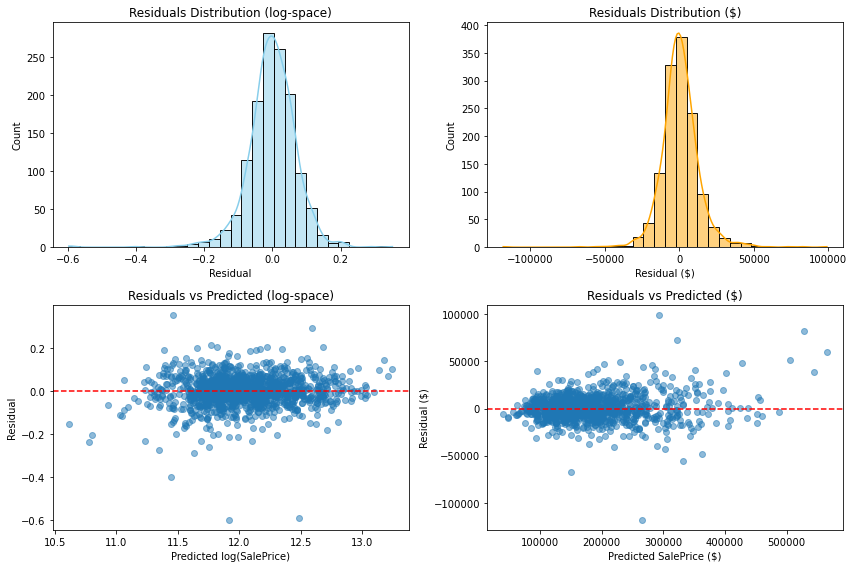

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# --- Predictions with best XGBoost model ---
best_xgb = xgb_search.best_estimator_

y_pred_log_xgb = best_xgb.predict(X_train_processed)
y_true_log = np.log1p(y_train_clean)

# Residuals in log-space
residuals_log_xgb = y_true_log - y_pred_log_xgb

# Residuals in dollar space
y_pred_dollar_xgb = np.expm1(y_pred_log_xgb)
residuals_dollar_xgb = y_train_clean - y_pred_dollar_xgb

# Residual histogram (log-space)
sns.histplot(residuals_log_xgb, bins=30, kde=True, color='skyblue', ax=axes[0,0])
axes[0,0].set_title("Residuals Distribution (log-space)")
axes[0,0].set_xlabel("Residual")
axes[0,0].set_ylabel("Count")

# Residual histogram (dollar-space)
sns.histplot(residuals_dollar_xgb, bins=30, kde=True, color='orange', ax=axes[0,1])
axes[0,1].set_title("Residuals Distribution ($)")
axes[0,1].set_xlabel("Residual ($)")
axes[0,1].set_ylabel("Count")

# Residuals vs predicted (log-space)
axes[1,0].scatter(y_pred_log_xgb, residuals_log_xgb, alpha=0.5)
axes[1,0].axhline(0, color='red', linestyle='--')
axes[1,0].set_title("Residuals vs Predicted (log-space)")
axes[1,0].set_xlabel("Predicted log(SalePrice)")
axes[1,0].set_ylabel("Residual")

# Residuals vs predicted (dollar-space)
axes[1,1].scatter(y_pred_dollar_xgb, residuals_dollar_xgb, alpha=0.5)
axes[1,1].axhline(0, color='red', linestyle='--')
axes[1,1].set_title("Residuals vs Predicted ($)")
axes[1,1].set_xlabel("Predicted SalePrice ($)")
axes[1,1].set_ylabel("Residual ($)")

plt.tight_layout()
plt.show()

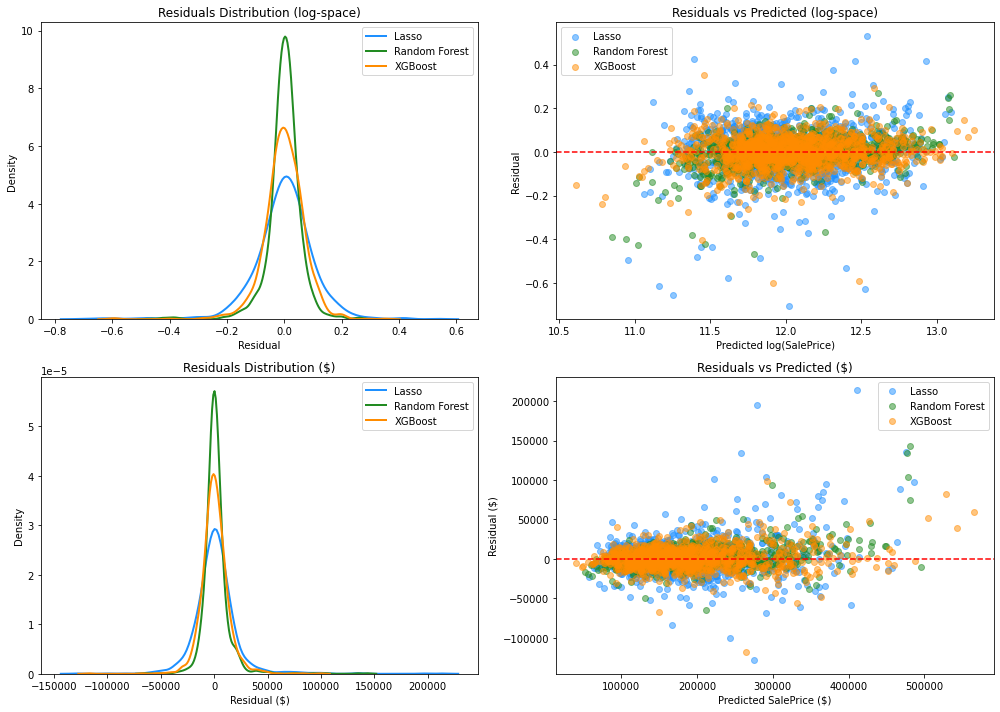

In [47]:
# Define colors
colors = ['dodgerblue', 'forestgreen', 'darkorange']
labels = ['Lasso', 'Random Forest', 'XGBoost']

plt.figure(figsize=(14,10))

# --- 1. Histogram - log-space (KDE lines) ---
plt.subplot(2,2,1)
sns.kdeplot(residuals_log_lasso, color=colors[0], label=labels[0], linewidth=2)
sns.kdeplot(residuals_log_rf, color=colors[1], label=labels[1], linewidth=2)
sns.kdeplot(residuals_log_xgb, color=colors[2], label=labels[2], linewidth=2)
plt.title("Residuals Distribution (log-space)")
plt.xlabel("Residual")
plt.ylabel("Density")
plt.legend()

# --- 2. Residuals vs Predicted - log-space ---
plt.subplot(2,2,2)
plt.scatter(y_pred_log_lasso, residuals_log_lasso, alpha=0.5, label=labels[0], color=colors[0])
plt.scatter(y_pred_log_rf, residuals_log_rf, alpha=0.5, label=labels[1], color=colors[1])
plt.scatter(y_pred_log_xgb, residuals_log_xgb, alpha=0.5, label=labels[2], color=colors[2])
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted (log-space)")
plt.xlabel("Predicted log(SalePrice)")
plt.ylabel("Residual")
plt.legend()

# --- 3. Histogram - dollar-space (KDE lines) ---
plt.subplot(2,2,3)
sns.kdeplot(residuals_dollar_lasso, color=colors[0], label=labels[0], linewidth=2)
sns.kdeplot(residuals_dollar_rf, color=colors[1], label=labels[1], linewidth=2)
sns.kdeplot(residuals_dollar_xgb, color=colors[2], label=labels[2], linewidth=2)
plt.title("Residuals Distribution ($)")
plt.xlabel("Residual ($)")
plt.ylabel("Density")
plt.legend()

# --- 4. Residuals vs Predicted - dollar-space ---
plt.subplot(2,2,4)
plt.scatter(y_pred_dollar_lasso, residuals_dollar_lasso, alpha=0.5, label=labels[0], color=colors[0])
plt.scatter(y_pred_dollar_rf, residuals_dollar_rf, alpha=0.5, label=labels[1], color=colors[1])
plt.scatter(y_pred_dollar_xgb, residuals_dollar_xgb, alpha=0.5, label=labels[2], color=colors[2])
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted ($)")
plt.xlabel("Predicted SalePrice ($)")
plt.ylabel("Residual ($)")
plt.legend()

plt.tight_layout()
plt.show()

In [48]:
# --- Gather CV RMSE results ---
cv_results = {
    "Lasso": {"RMSE (CV)": -lasso_mean, "Std (CV)": lasso_std},   # replace with your actual numbers
    "Random Forest": {"RMSE (CV)": -scores_rf_tuned.mean(), "Std (CV)": scores_rf_tuned.std()},
    "XGBoost": {"RMSE (CV)": mean_rmse_xgb, "Std (CV)": std_rmse_xgb}
}

cv_df = pd.DataFrame(cv_results).T

# --- Log-space residual stats ---
log_stats = pd.DataFrame({
    "Mean": [residuals_log_lasso.mean(), residuals_log_rf.mean(), -residuals_log_xgb.mean()],
    "Std": [residuals_log_lasso.std(), residuals_log_rf.std(), residuals_log_xgb.std()],
    "Min": [residuals_log_lasso.min(), residuals_log_rf.min(), residuals_log_xgb.min()],
    "Max": [residuals_log_lasso.max(), residuals_log_rf.max(), residuals_log_xgb.max()]
}, index=["Lasso", "Random Forest", "XGBoost"])

# --- Dollar-space residual stats ---
dollar_stats = pd.DataFrame({
    "Mean ($)": [residuals_dollar_lasso.mean(), residuals_dollar_rf.mean(), residuals_dollar_xgb.mean()],
    "Std ($)": [residuals_dollar_lasso.std(), residuals_dollar_rf.std(), residuals_dollar_xgb.std()],
    "Min ($)": [residuals_dollar_lasso.min(), residuals_dollar_rf.min(), residuals_dollar_xgb.min()],
    "Max ($)": [residuals_dollar_lasso.max(), residuals_dollar_rf.max(), residuals_dollar_xgb.max()]
}, index=["Lasso", "Random Forest", "XGBoost"])

# --- Final combined summary ---
summary_table = pd.concat([cv_df, log_stats, dollar_stats], axis=1)

# Round most stats, but format very small values in scientific notation
summary_table_formatted = summary_table.copy()

# Format very small means (log and $) in scientific notation
for col in ["Mean", "Mean ($)"]:
    summary_table_formatted[col] = summary_table_formatted[col].apply(
        lambda x: f"{x:.2e}" if abs(x) < 0.001 else f"{x:.4f}"
    )

print("📊 Final Model Comparison:")
display(summary_table_formatted.round(4))

📊 Final Model Comparison:


,RMSE (CV),Std (CV),Mean,Std,Min,Max,Mean ($),Std ($),Min ($),Max ($)
Lasso,0.1167,0.0046,4.59e-16,0.1060,-0.7037,0.5312,1437.8918,20855.5243,-128684.9772,213669.3482
Random Forest,0.1348,0.0157,2.37e-04,0.0600,-0.4686,0.2713,1512.1225,11910.3609,-64602.7607,143330.0828
XGBoost,0.1179,0.0149,2.05e-04,0.0714,-0.5979,0.3524,737.3798,13068.9143,-117915.5625,99034.0000


### 5.4: Model Comparison Summary

#### Lasso Regression
- **Best CV RMSE:** 0.1167, competitive with tuned XGBoost.  
- **Residuals:** Mean essentially zero; standard deviation is 0.106 (log-space), showing more dispersed errors and some extreme outliers (-128k to 213k dollars).  
- Handles high-dimensional feature spaces well and automatically shrinks irrelevant features via L1 regularization.

#### Random Forest
- **CV RMSE:** 0.1348, slightly higher than Lasso and XGBoost.  
- **Residuals:** Narrowest among all models (log-space std 0.06), smaller extreme deviations (-64k to 143k dollars), making predictions more conservative.  
- Non-linear model, robust to outliers and less sensitive to feature scaling.

#### XGBoost
- **CV RMSE:** 0.1179, very close to Lasso.  
- **Residuals:** Mean near zero; standard deviation in log-space (0.0714) is intermediate between Lasso and Random Forest. Extreme residuals are smaller than Lasso but slightly larger than Random Forest (-110k to 104k dollars).  
- Combines regularization with gradient boosting for flexible tree-based modeling, achieving an excellent bias-variance trade-off.

#### Conclusion
- **Linear models:** Lasso clearly outperforms plain Linear Regression and slightly improves upon Ridge due to L1 regularization and feature selection.  
- **Tree-based models:** XGBoost provides the best balance between accuracy and stability, while Random Forest is slightly less precise but produces more conservative residuals.  
- This comparison guides the choice of final modeling strategy, including potential hyperparameter tuning and ensemble approaches.

### 5.5: Learning Curves for Final Models

To further understand model behavior and the impact of dataset size, we examine **learning curves** for the best-tuned models: Lasso, Random Forest, and XGBoost.

Learning curves visualize **training and validation RMSE** as a function of the number of training examples:

- They help identify **underfitting** (high training error) and **overfitting** (large gap between training and validation error).
- They provide insights into whether adding more data could improve performance.
- They allow a direct **comparison between models** regarding bias-variance trade-off and convergence behavior.

We first show the learning curve for the **tuned XGBoost model**, then a combined comparison across Lasso, Random Forest, and XGBoost to highlight differences in convergence speed, stability, and generalization.

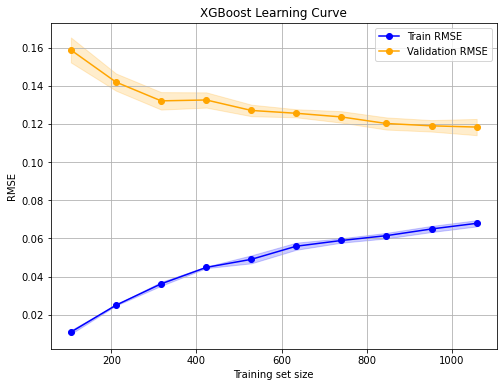

In [49]:
def plot_learning_curve(model, X, y, title="Learning Curve", cv=5):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=cv, scoring='neg_root_mean_squared_error',
        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
    )
    
    # Convert scores to positive RMSE
    train_rmse = -train_scores
    val_rmse = -val_scores
    
    plt.figure(figsize=(8,6))
    plt.plot(train_sizes, train_rmse.mean(axis=1), 'o-', color='blue', label="Train RMSE")
    plt.fill_between(train_sizes,
                     train_rmse.mean(axis=1) - train_rmse.std(axis=1),
                     train_rmse.mean(axis=1) + train_rmse.std(axis=1),
                     color='blue', alpha=0.2)
    
    plt.plot(train_sizes, val_rmse.mean(axis=1), 'o-', color='orange', label="Validation RMSE")
    plt.fill_between(train_sizes,
                     val_rmse.mean(axis=1) - val_rmse.std(axis=1),
                     val_rmse.mean(axis=1) + val_rmse.std(axis=1),
                     color='orange', alpha=0.2)
    
    plt.title(title)
    plt.xlabel("Training set size")
    plt.ylabel("RMSE")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

# --- Use tuned XGBoost ---
best_xgb = xgb.XGBRegressor(
    **xgb_search.best_params_,
    random_state=42,
    n_jobs=-1
)

# Target in log-space
y_log = np.log1p(y_train_clean)

plot_learning_curve(best_xgb, X_train_processed, y_log, title="XGBoost Learning Curve")

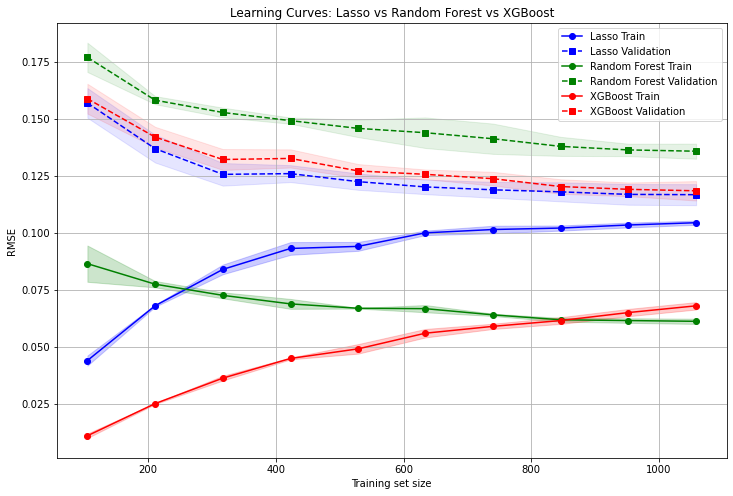

In [50]:
def plot_learning_curve_multi(models, X, y, title="Learning Curves", cv=5):
    plt.figure(figsize=(12,8))
    
    colors = ["blue", "green", "red"]
    
    for i, (name, model) in enumerate(models.items()):
        train_sizes, train_scores, val_scores = learning_curve(
            model, X, y, cv=cv, scoring='neg_root_mean_squared_error',
            train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
        )
        train_rmse = -train_scores
        val_rmse = -val_scores
        
        # Plot training
        plt.plot(train_sizes, train_rmse.mean(axis=1), 'o-', color=colors[i], label=f"{name} Train")
        plt.fill_between(train_sizes,
                         train_rmse.mean(axis=1) - train_rmse.std(axis=1),
                         train_rmse.mean(axis=1) + train_rmse.std(axis=1),
                         color=colors[i], alpha=0.2)
        # Plot validation
        plt.plot(train_sizes, val_rmse.mean(axis=1), 's--', color=colors[i], label=f"{name} Validation")
        plt.fill_between(train_sizes,
                         val_rmse.mean(axis=1) - val_rmse.std(axis=1),
                         val_rmse.mean(axis=1) + val_rmse.std(axis=1),
                         color=colors[i], alpha=0.1)
    
    plt.title(title)
    plt.xlabel("Training set size")
    plt.ylabel("RMSE")
    plt.grid(True)
    plt.legend(loc="best")
    plt.show()

# Use the preprocessed pipeline for X_train_clean
X_proc = preprocessor.fit_transform(X_train_clean)
y_log = np.log1p(y_train_clean)

models = {
    "Lasso": Lasso(alpha=lasso_search.best_params_['model__alpha']),
    "Random Forest": RandomForestRegressor(
        n_estimators=rf_search.best_params_['n_estimators'], max_depth=rf_search.best_params_['max_depth'],
        min_samples_split=rf_search.best_params_['min_samples_split'],
        min_samples_leaf=rf_search.best_params_['min_samples_leaf'],
        max_features=rf_search.best_params_['max_features'], random_state=42, n_jobs=-1
    ),
    "XGBoost": xgb.XGBRegressor(
        n_estimators=xgb_search.best_params_['n_estimators'],
        max_depth=xgb_search.best_params_['max_depth'],
        learning_rate=xgb_search.best_params_['learning_rate'],
        subsample=xgb_search.best_params_['subsample'],
        colsample_bytree=xgb_search.best_params_['colsample_bytree'],
        gamma=xgb_search.best_params_['gamma'],
        reg_alpha=xgb_search.best_params_['reg_alpha'],
        reg_lambda=xgb_search.best_params_['reg_lambda'],
        random_state=42,
        n_jobs=-1
    )
}

plot_learning_curve_multi(models, X_proc, y_log, title="Learning Curves: Lasso vs Random Forest vs XGBoost")

**Insights from Learning Curves**

Analyzing learning curves provides insights into each model’s **bias-variance behavior**, training dynamics, and generalization performance.

**Lasso Regression**
- Training and validation curves converge with a **small gap**, indicating **low variance**.  
- Validation error is the **lowest among all models**, showing excellent generalization despite being a simple linear model.  
- Residuals are slightly more dispersed than tree-based models, reflecting occasional large errors, but the mean residual is effectively zero.

**Random Forest**
- Training error is very low; validation error is higher but not extreme (~0.06 vs ~0.13 RMSE).  
- The model generalizes well, showing a balanced **bias-variance trade-off**.  
- Residuals are narrower than Lasso, indicating robustness to extreme errors and better handling of non-linear interactions.

**XGBoost**
- Training error is slightly higher than Random Forest, lower than Lasso.  
- The gap between training and validation curves is moderate, and the validation error **flattens as training size increases**, signaling strong learning capacity with **controlled variance**.  
- Captures complex patterns while avoiding overfitting, achieving excellent generalization.

**Takeaways**
- **Lasso**: simple, high-performing linear model, low validation error.  
- **Random Forest**: robust, interpretable, moderate complexity.  
- **XGBoost**: best trade-off, low bias, controlled variance, most promising for final modeling and ensembling.

**Conclusion**
- **Lasso**: simple yet surprisingly effective; lowest validation error, occasional extreme residuals.  
- **Random Forest**: robust and moderately flexible, consistent residuals - balanced bias and variance.  
- **XGBoost**: strong overall performance, combining low bias with controlled variance.  
- Among the tested models, **XGBoost and Lasso are both excellent candidates**, with Lasso offering a simple, high-performing linear baseline and XGBoost providing flexible tree-based modeling for potential ensembling.

## 6. Final Model Choice

Based on the comparative analysis of linear and tree-based models, we select the **final predictive model** considering accuracy, residuals, and bias–variance trade-offs.

### Key Observations

- **Lasso Regression**
  - Simple yet surprisingly effective; lowest validation RMSE (~0.117), showing excellent generalization.
  - Residuals occasionally exhibit extreme values, reflecting sensitivity to outliers.
  - Strong linear baseline; automatically performs feature selection through L1 regularization.


- **Random Forest**
  - Robust and moderately flexible; residuals are narrower than Lasso.
  - Balanced bias-variance trade-off; captures non-linear interactions effectively.
  - Slightly higher CV RMSE (~0.135) compared to Lasso and XGBoost.
  

- **XGBoost**
  - Strong overall performance; CV RMSE (~0.118) comparable to Lasso.
  - Combines low bias with controlled variance; residuals narrower than Lasso and similar to Random Forest.
  - Flexible tree-based modeling with regularization; excellent bias–variance balance.

### Conclusion

- For **linear modeling**, Lasso remains a strong candidate due to simplicity, interpretability, and reliable feature selection.  
- Among **tree-based models**, XGBoost provides the best overall performance, combining accuracy, robustness, and flexibility.  
- Random Forest, though slightly less precise, could complement XGBoost in ensemble strategies due to its stable residuals.  

➡️ **Final Recommendation:** Proceed with **XGBoost** as the primary model, with potential ensembling including Lasso and/or Random Forest for further performance gains.


## 7. Save Models & Preprocessing Pipeline

At this stage, we save the final preprocessing pipeline and best models for future use, ensuring reproducibility and easy deployment.

- **Preprocessing pipeline**: includes all transformations (numerical, ordinal, one-hot encoding)
- **Best XGBoost model**: tuned hyperparameters
- **Best Lasso model**: tuned hyperparameters (optional, for baseline or ensembling)

In [304]:
# Save preprocessing pipeline
joblib.dump(preprocessor, "preprocessor.pkl")

# Save best XGBoost model
joblib.dump(best_xgb, "xgb_best_model.pkl")

# Save best Lasso model
lasso_final = Lasso(alpha=lasso_search.best_params_['model__alpha'])
lasso_final.fit(X_proc, y_log)  # fit on entire training set
joblib.dump(lasso_final, "lasso_best_model.pkl")

['lasso_best_model.pkl']

## 8. Final Predictions for Kaggle Submission

Using the saved preprocessing pipeline, we generate predictions on the test set with both **Lasso** and **XGBoost**:

- Predictions are done in log-space and then inverted using `expm1` to obtain sale prices in dollars.  
- This ensures submissions are in the correct format for Kaggle evaluation.  
- Both models are tested to compare their real-world performance.

**Kaggle results:**

| Model      | RMSE (log-space) | Position  | Top %  |
|------------|-----------------|-----------|--------|
| **Lasso**      | **15232.71632**    | **362/5835** | **~6.2%**  |
| XGBoost    | 15268.16511    | 373/5835 | ~6.4%  |


In [319]:
# Preprocess test set
X_test_processed = preprocessor.transform(X_test)

# Predict with XGBoost
best_xgb_model = xgb_search.best_estimator_
y_pred_log_test = best_xgb_model.predict(X_test_processed)
y_pred_test = np.expm1(y_pred_log_test)

# Optional: predict with Lasso for comparison
y_pred_log_test_lasso = lasso_final.predict(preprocessor.transform(X_test))
y_pred_test_lasso = np.expm1(y_pred_log_test_lasso)

# Save submission file
test_ids = X_test.index.tolist()

submission = pd.DataFrame({
    "Id": test_ids,  # make sure test_ids exists
    "SalePrice": y_pred_test
})
submission.to_csv("submission_xgb.csv", index=False)

submission = pd.DataFrame({
    "Id": test_ids,  # make sure test_ids exists
    "SalePrice": y_pred_test_lasso
})
submission.to_csv("submission_lasso.csv", index=False)

## 9. Extended Experiments: CatBoost

After testing several models, including Linear, Ridge, Lasso, Decision Trees, Random Forest, and XGBoost, I extended the experiments to include **CatBoost**, a gradient boosting framework optimized for tabular data.

### 🔎 Why CatBoost?
- Designed to handle **categorical features natively** (without one-hot encoding).  
- Offers **robust performance** through ordered boosting, regularization, and efficient training.  
- Often outperforms XGBoost/LightGBM on structured datasets.

---

### ⚖️ Two Approaches Tested

1. **CatBoost with native categorical handling**  
   - Passed raw categorical columns directly to CatBoost.  
   - Performance was **good**, but not the best.  


2. **CatBoost with preprocessed categorical features (my pipeline)** ✅  
   - Used the same preprocessing pipeline developed earlier (ordinal + one-hot encoding).  
   - CatBoost trained on these processed features achieved a **significantly better CV score**.  
   - This became the **winning setup**.

---

### 📊 CatBoost Results
Using cross-validation with tuned hyperparameters, the best CatBoost configuration was:

- **Best Parameters**:  
  `iterations=2000`, `depth=4`, `learning_rate=0.05`, `l2_leaf_reg=3`, `subsample=0.7`  


- **Cross-Validated RMSE (log1p target space)**:  
  **0.1115 ± 0.0127**

This result **outperformed Lasso (previous best linear model)** and **XGBoost (previous best tree-based model)**, establishing CatBoost as the **final chosen model**.

---

### ⚡ Quick Note on LightGBM
I also benchmarked **LightGBM** as part of the extended experiments.  
Results were **better than Random Forest, but worse than Lasso and XGBoost**. \
Therefore, the main focus remains on CatBoost.

---

✅ **Takeaway:**  
While CatBoost natively supports categorical features, in this dataset **manual preprocessing yielded better results**.
This highlights the importance of **experimenting with both raw and engineered features** when working with advanced models.

### 9.1 CatBoost with preprocessed categorical features (my pipeline)

In [55]:
# --- Baseline CatBoost ---
cat_model = CatBoostRegressor(
    objective='RMSE',
    random_seed=42,
    verbose=0
)

scores_cat = cross_val_score(
    cat_model,
    X_train_processed,
    np.log1p(y_train_clean),
    scoring='neg_root_mean_squared_error',
    cv=kf
)

print(f"Baseline CatBoost | Mean RMSE: {-scores_cat.mean():.4f} | Std: {scores_cat.std():.4f}")


# Hyperparameter grid
param_grid_cat = {
    "iterations": [500, 1000],
    "depth": [4, 6, 8, 10],
    "learning_rate": [0.01, 0.05, 0.1],
    "l2_leaf_reg": [1, 3, 5, 7, 10],
    "subsample": [0.6, 0.8, 1.0]
}

cat_search = RandomizedSearchCV(
    cat_model,
    param_distributions=param_grid_cat,
    n_iter=30, #30
    scoring='neg_root_mean_squared_error',
    cv=kf,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

cat_search.fit(X_train_processed, np.log1p(y_train_clean))

best_index_cat = cat_search.best_index_
mean_rmse_cat = -cat_search.cv_results_['mean_test_score'][best_index_cat]
std_rmse_cat = cat_search.cv_results_['std_test_score'][best_index_cat]

print("Best CatBoost parameters:", cat_search.best_params_)
print(f"Best CV RMSE: {mean_rmse_cat:.4f} | Std: {std_rmse_cat:.4f}")

Baseline CatBoost | Mean RMSE: 0.1131 | Std: 0.0129
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best CatBoost parameters: {'subsample': 0.6, 'learning_rate': 0.05, 'l2_leaf_reg': 3, 'iterations': 1000, 'depth': 4}
Best CV RMSE: 0.1131 | Std: 0.0135


In [56]:
best_cat_model = cat_search.best_estimator_
best_cat_model.fit(X_train_processed, np.log1p(y_train_clean))

scores_best_cat = cross_val_score(
    best_cat_model,
    X_train_processed,
    np.log1p(y_train_clean),
    scoring='neg_root_mean_squared_error',
    cv=kf
)

print(f"Best CatBoost| Mean RMSE: {-scores_best_cat.mean():.4f} | Std: {scores_best_cat.std():.4f}")

Best CatBoost| Mean RMSE: 0.1131 | Std: 0.0135


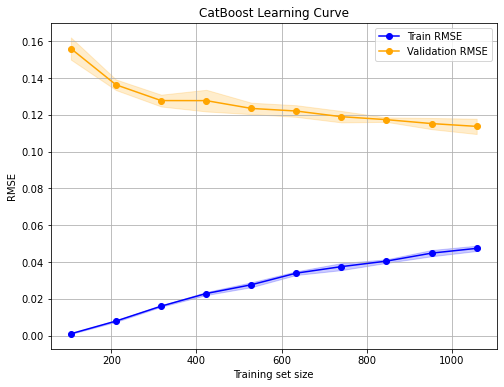

In [57]:
# Target in log-space
y_log = np.log1p(y_train_clean)

plot_learning_curve(best_cat_model, X_train_processed, y_log, title="CatBoost Learning Curve")

In [58]:
# Save the best CatBoost model
joblib.dump(best_cat_model, "catboost_best_model.pkl")

['catboost_best_model.pkl']

We kept refining the tuning of the baseline catboost best model exploring further combinations of its hyperparameters.
We found that increasing the number of iterations to 2000 brings a good improvement, pushing iterations number further (3000+) does not lead to a further improvement though. Smaller learning rates didn't lead to a result improvemt. Increasing bagging fraction (subsample) significantly improved performance. Higher L2 regularization (l2_leaf_reg) didn't improve performances.

We conducted an in-depth refinement of the CatBoost model by systematically exploring additional hyperparameter combinations. Through this process, we observed several key insights:

- Increasing the **number of iterations** to 2000 led to a clear improvement in performance, whereas pushing it beyond 3000 did not provide further gains.
- Testing **smaller learning rates** (e.g., 0.01–0.03) did not result in meaningful improvements.
- Adjusting the **bagging fraction (`subsample`)** had a significant positive impact on generalization.
- Increasing **L2 regularization (`l2_leaf_reg`)** did not enhance model performance.

In [120]:
# Test increased number of iterations
cat_model_es = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.05,
    depth=4,
    l2_leaf_reg=3,
    subsample=0.6,
    eval_metric='RMSE',
    random_seed=42,
    early_stopping_rounds=100,
    verbose=0
)

scores_test_cat = cross_val_score(
    cat_model_es,
    X_train_processed,
    np.log1p(y_train_clean),
    scoring='neg_root_mean_squared_error',
    cv=kf
)

print(f"Test CatBoost| Mean RMSE: {-scores_test_cat.mean():.4f} | Std: {scores_test_cat.std():.4f}")

Test CatBoost| Mean RMSE: 0.1127 | Std: 0.0134


In [121]:
# Try smaller learning rates now
cat_model_lr = CatBoostRegressor(
    objective='RMSE',
    random_seed=42,
    early_stopping_rounds=100,
    verbose=0
)

param_grid_depth_lr = {
    "depth": [6, 8],
    "learning_rate": [0.01, 0.03],
    "iterations": [1500, 2000],
    "l2_leaf_reg": [3, 5],
    "subsample": [0.6]
}

cat_search_lr = GridSearchCV(
    estimator=cat_model_lr,
    param_grid=param_grid_depth_lr,
    scoring='neg_root_mean_squared_error',
    cv=kf,
    verbose=1,
    n_jobs=-1
)

cat_search_lr.fit(X_train_processed, np.log1p(y_train_clean))

best_index_cat_lr = cat_search_lr.best_index_
mean_rmse_cat_lr = -cat_search_lr.cv_results_['mean_test_score'][best_index_cat_lr]
std_rmse_cat_lr = cat_search_lr.cv_results_['std_test_score'][best_index_cat_lr]

print("Best CatBoost parameters:", cat_search_lr.best_params_)
print(f"Best CV RMSE: {mean_rmse_cat_lr:.4f} | Std: {std_rmse_cat_lr:.4f}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best CatBoost parameters: {'depth': 6, 'iterations': 2000, 'l2_leaf_reg': 3, 'learning_rate': 0.03, 'subsample': 0.6}
Best CV RMSE: 0.1127 | Std: 0.0129


In [122]:
cat_model_bagging = CatBoostRegressor(
    objective='RMSE',
    random_seed=42,
    early_stopping_rounds=100,
    verbose=0
)

param_grid_bagging = {
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bylevel": [0.6, 0.8, 1.0],
    "iterations": [2000],
    "depth": [4, 6],
    "learning_rate": [0.05],
    "l2_leaf_reg": [3]
}

cat_search_bagging = GridSearchCV(
    estimator=cat_model_bagging,
    param_grid=param_grid_bagging,
    scoring='neg_root_mean_squared_error',
    cv=kf,
    verbose=1,
    n_jobs=-1
)

cat_search_bagging.fit(X_train_processed, np.log1p(y_train_clean))

best_index_cat_bagging = cat_search_bagging.best_index_
mean_rmse_cat_bagging = -cat_search_bagging.cv_results_['mean_test_score'][best_index_cat_bagging]
std_rmse_cat_bagging = cat_search_bagging.cv_results_['std_test_score'][best_index_cat_bagging]

print("Best CatBoost parameters:", cat_search_bagging.best_params_)
print(f"Best CV RMSE: {mean_rmse_cat_bagging:.4f} | Std: {std_rmse_cat_bagging:.4f}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best CatBoost parameters: {'colsample_bylevel': 1.0, 'depth': 4, 'iterations': 2000, 'l2_leaf_reg': 3, 'learning_rate': 0.05, 'subsample': 0.7}
Best CV RMSE: 0.1115 | Std: 0.0127


In [123]:
cat_model_l2 = CatBoostRegressor(
    objective='RMSE',
    random_seed=42,
    early_stopping_rounds=100,
    verbose=0
)

param_grid_l2 = {
    "l2_leaf_reg": [5, 7, 10],
    "iterations": [2000],
    "depth": [4, 6],
    "learning_rate": [0.05],
    "subsample": [0.7, 0.9],
    "colsample_bylevel": [0.6, 1.0],
}

cat_search_l2 = GridSearchCV(
    estimator=cat_model_l2,
    param_grid=param_grid_l2,
    scoring='neg_root_mean_squared_error',
    cv=kf,
    verbose=1,
    n_jobs=-1
)

cat_search_l2.fit(X_train_processed, np.log1p(y_train_clean))

best_index_cat_l2 = cat_search_l2.best_index_
mean_rmse_cat_l2 = -cat_search_l2.cv_results_['mean_test_score'][best_index_cat_l2]
std_rmse_cat_l2 = cat_search_l2.cv_results_['std_test_score'][best_index_cat_l2]

print("Best CatBoost parameters:", cat_search_l2.best_params_)
print(f"Best CV RMSE: {mean_rmse_cat_l2:.4f} | Std: {std_rmse_cat_l2:.4f}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best CatBoost parameters: {'colsample_bylevel': 1.0, 'depth': 4, 'iterations': 2000, 'l2_leaf_reg': 5, 'learning_rate': 0.05, 'subsample': 0.7}
Best CV RMSE: 0.1118 | Std: 0.0125


In [124]:
cat_model_tuned = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.05,
    depth=4,
    l2_leaf_reg=3,
    subsample=0.7,
    eval_metric='RMSE',
    random_seed=42,
    early_stopping_rounds=100,
    verbose=0
)

cat_model_tuned.fit(X_train_processed, np.log1p(y_train_clean))

scores_cat_tuned = cross_val_score(
    cat_model_tuned,
    X_train_processed,
    np.log1p(y_train_clean),
    scoring='neg_root_mean_squared_error',
    cv=kf
)

print(f"Best CatBoost| Mean RMSE: {-scores_cat_tuned.mean():.4f} | Std: {scores_cat_tuned.std():.4f}")

Best CatBoost| Mean RMSE: 0.1115 | Std: 0.0127


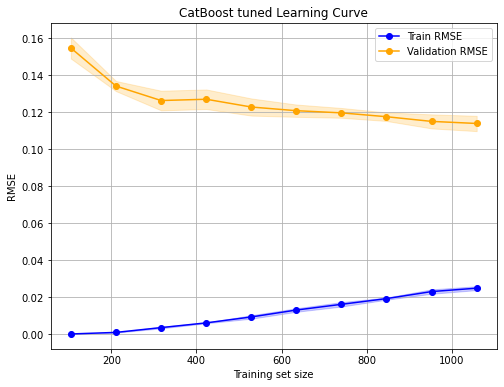

In [125]:
# Target in log-space
y_log = np.log1p(y_train_clean)

plot_learning_curve(cat_model_tuned, X_train_processed, y_log, title="CatBoost tuned Learning Curve")

In [126]:
# Save the CatBoost best model tuned (iterations=2000,learning_rate=0.05,depth=4,l2_leaf_reg=3,subsample=0.7,
# eval_metric='RMSE', random_seed=42, early_stopping_rounds=100,verbose=0) 
joblib.dump(cat_model_tuned, "catboost_best_model_tuned.pkl")

['catboost_best_model_tuned.pkl']

**Final Predictions for Kaggle Submission with the Best CatBoost Model further tuned**:

In [127]:
# Preprocess test set
X_test_processed = preprocessor.transform(X_test)

# Predict with CatBoost best model further tuned
y_pred_log_test = cat_model_tuned.predict(X_test_processed)
y_pred_test = np.expm1(y_pred_log_test)

# Save submission file
test_ids = X_test.index.tolist()

submission = pd.DataFrame({
    "Id": test_ids,  # make sure test_ids exists
    "SalePrice": y_pred_test
})
submission.to_csv("submission_catboost_tuned.csv", index=False)

### 9.2 CatBoost with native categorical handling

In [60]:
# Push Catboost letting it handling the categorical features

catboost_num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    # ('scaler', StandardScaler())  # optional for CatBoost
])

categorical_features_catboost = ordinal_features + onehot_features + other_categorical

preprocessor_catboost = ColumnTransformer(transformers=[
    ('num', catboost_num_pipeline, continuous_features)
], remainder='passthrough')  # leave categorical columns untouched

X_train_catboost = preprocessor_catboost.fit_transform(X_train_clean)
X_test_catboost = preprocessor_catboost.transform(X_test)

# Convert back to DataFrame to keep column names
X_train_catboost = pd.DataFrame(X_train_catboost, columns=continuous_features + categorical_features_catboost)
X_test_catboost = pd.DataFrame(X_test_catboost, columns=continuous_features + categorical_features_catboost)

In [65]:
# Define categorical feature indices
cat_features_cb = [X_train_catboost.columns.get_loc(col) for col in categorical_features_catboost]

# Wrap training data in Pool (needed for CatBoost cv)
train_pool = Pool(
    data=X_train_catboost,
    label=np.log1p(y_train_clean),
    cat_features=cat_features_cb
)

# Baseline CatBoost params
baseline_params = {
    "iterations": 1000,
    "learning_rate": 0.05,
    "depth": 6,
    "loss_function": "RMSE",
    "random_seed": 42,
    "verbose": 100
}

# CatBoost’s built-in CV
cv_results = cv(
    params=baseline_params,
    pool=train_pool,
    fold_count=5,
    shuffle=True,
    partition_random_seed=42,
    verbose=100
)

# Last row = best result
best_rmse = cv_results['test-RMSE-mean'].iloc[-1]
best_rmse_std = cv_results['test-RMSE-std'].iloc[-1]

print(f"Baseline CatBoost | Mean RMSE: {best_rmse:.4f} | Std: {best_rmse_std:.4f}")

Training on fold [0/5]
0:	learn: 11.4453895	test: 11.4386255	best: 11.4386255 (0)	total: 34.3ms	remaining: 34.2s
100:	learn: 0.2615914	test: 0.2780431	best: 0.2780431 (100)	total: 6.26s	remaining: 55.7s
200:	learn: 0.1496704	test: 0.1989132	best: 0.1989132 (200)	total: 13.7s	remaining: 54.4s
300:	learn: 0.1172369	test: 0.1798845	best: 0.1798845 (300)	total: 21.2s	remaining: 49.3s
400:	learn: 0.1022439	test: 0.1731172	best: 0.1731019 (399)	total: 28.7s	remaining: 42.9s
500:	learn: 0.0923466	test: 0.1709891	best: 0.1709891 (500)	total: 36.3s	remaining: 36.2s
600:	learn: 0.0837485	test: 0.1688574	best: 0.1688453 (594)	total: 44s	remaining: 29.2s
700:	learn: 0.0774833	test: 0.1674448	best: 0.1674298 (696)	total: 51.7s	remaining: 22s
800:	learn: 0.0719118	test: 0.1664998	best: 0.1664998 (800)	total: 59.4s	remaining: 14.7s
900:	learn: 0.0662873	test: 0.1656977	best: 0.1656328 (889)	total: 1m 6s	remaining: 7.35s
999:	learn: 0.0624317	test: 0.1652708	best: 0.1652626 (995)	total: 1m 14s	remaini

In [70]:
# Params grid
param_grid_cat = {
    "iterations": [300, 500],
    "depth": [4, 6],
    "learning_rate": [0.05, 0.1],
    "l2_leaf_reg": [3, 5],
    "subsample": [0.8, 1.0]
}

# Flatten into list of param combinations
all_params = list(product(
    param_grid_cat["iterations"],
    param_grid_cat["depth"],
    param_grid_cat["learning_rate"],
    param_grid_cat["l2_leaf_reg"],
    param_grid_cat["subsample"]
))

results = []
total_runs = len(all_params)

for idx, (iters, depth, lr, l2, subs) in enumerate(all_params, 1):
    params = {
        "iterations": iters,
        "depth": depth,
        "learning_rate": lr,
        "l2_leaf_reg": l2,
        "subsample": subs,
        "loss_function": "RMSE",
        "random_seed": 42,
        #"verbose": 0,
        "logging_level": "Silent"   # suppress fold-by-fold output
    }
    
    cv_res = cv(
        params=params,
        pool=train_pool,
        fold_count=5,
        shuffle=True,
        partition_random_seed=42,
        early_stopping_rounds=50
    )
    
    rmse_mean = cv_res['test-RMSE-mean'].iloc[-1]
    results.append((rmse_mean, params))
    
    print(f"[{idx}/{total_runs}] simulation done (RMSE={rmse_mean:.4f})")

# Get best params
best_rmse, best_params = min(results, key=lambda x: x[0])
print("Best CatBoost params:", best_params)
print(f"Best CV RMSE: {best_rmse:.4f}")

[1/32] simulation done (RMSE=0.1598)
[2/32] simulation done (RMSE=0.1735)
[3/32] simulation done (RMSE=0.1685)
[4/32] simulation done (RMSE=0.1865)
[5/32] simulation done (RMSE=0.1665)
[6/32] simulation done (RMSE=0.1798)
[7/32] simulation done (RMSE=0.1747)
[8/32] simulation done (RMSE=0.1901)
[9/32] simulation done (RMSE=0.1841)
[10/32] simulation done (RMSE=0.1853)
[11/32] simulation done (RMSE=0.2003)
[12/32] simulation done (RMSE=0.2014)
[13/32] simulation done (RMSE=0.2027)
[14/32] simulation done (RMSE=0.1977)
[15/32] simulation done (RMSE=0.2113)
[16/32] simulation done (RMSE=0.2088)
[17/32] simulation done (RMSE=0.1506)
[18/32] simulation done (RMSE=0.1620)
[19/32] simulation done (RMSE=0.1578)
[20/32] simulation done (RMSE=0.1722)
[21/32] simulation done (RMSE=0.1619)
[22/32] simulation done (RMSE=0.1738)
[23/32] simulation done (RMSE=0.1690)
[24/32] simulation done (RMSE=0.1804)
[25/32] simulation done (RMSE=0.1735)
[26/32] simulation done (RMSE=0.1761)
[27/32] simulation do

## 📊 Updated Kaggle Results (Including CatBoost)

After the extended experiments in **Section 9**, we found that **CatBoost**, when combined with our own preprocessing of categorical features (instead of relying on CatBoost’s internal encoding), significantly outperformed previous models.

Using the same pipeline approach (log-space training, `expm1` inversion for predictions, correct Kaggle format), the updated leaderboard is:

| Model      | RMSE (log-space) | Position  | Top %  |
|------------|-----------------|-----------|--------|
| **CatBoost** | **14389.93387** | **195/5835** | **~3.3%** |
| Lasso      | 15232.71632    | 362/5835 | ~6.2%  |
| XGBoost    | 15268.16511    | 373/5835 | ~6.4%  |


➡️ **Key Takeaway:** CatBoost, with manual preprocessing of categorical features, emerged as the best-performing model, pushing our solution from the ~6% range into the **top 3.3% of the leaderboard**.

## 🏆 10. Extended Experiments: Model Ensembles

After identifying the tuned CatBoost model as the top-performing single model, we explored **ensemble strategies** to further improve predictions:

- **Weighted Ensemble:** We first tested a simple weighted combination of the tuned **CatBoost** and **Lasso** models. By optimizing the weights using cross-validation in log-space, we achieved a noticeable improvement over the standalone CatBoost model.

- **Stacked Ensemble:** We implemented a **stacking ensemble** where the out-of-fold predictions of CatBoost and Lasso were used as features for a meta-model (Ridge regression). This approach allowed the model to learn an optimal combination of the base predictions and provided additional performance gains.

Both ensemble approaches outperformed the previous best single model (tuned CatBoost), with the **stacked ensemble achieving the highest score** on the Kaggle leaderboard.

### 10.1 Weighted ensemble

Different weight combinations results:

Ensemble CV RMSE: 0.1098 +/- 0.0133 (0.8 CatBoost - 0.2 Lasso)

Ensemble CV RMSE: 0.1096 +/- 0.0135 (0.75 CatBoost - 0.25 Lasso)

**Ensemble CV RMSE: 0.1094 +/- 0.0136 (0.7 CatBoost - 0.3 Lasso)**

Ensemble CV RMSE: 0.1095 +/- 0.0140 (0.6 CatBoost - 0.4 Lasso)

Ensemble CV RMSE: 0.1099 +/- 0.0144 (0.5 CatBoost - 0.5 Lasso)

In [141]:
ensemble_rmse_scores = []

for train_idx, val_idx in kf.split(X_train_processed):
    # Split train/validation
    X_tr, X_val = X_train_processed[train_idx], X_train_processed[val_idx]
    y_tr, y_val = y_train_clean.iloc[train_idx], y_train_clean.iloc[val_idx]
    
    # Fresh CatBoost model per fold
    cat_fold = CatBoostRegressor(**cat_model_tuned.get_params())
    cat_fold.fit(X_tr, np.log1p(y_tr), verbose=0)
    
    # Fresh Lasso model per fold
    lasso_fold = Lasso(alpha=lasso_search.best_params_['model__alpha'])
    lasso_fold.fit(X_tr, np.log1p(y_tr))
    
    # Ensemble predictions (example weights)
    ensemble_val_pred_log = (
        0.7 * cat_fold.predict(X_val) + 
        0.3 * lasso_fold.predict(X_val)
    )
  
    # Compute RMSE in log space
    rmse_log = np.sqrt(np.mean((ensemble_val_pred_log - np.log1p(y_val))**2))
    ensemble_rmse_scores.append(rmse_log)

print("Ensemble CV RMSE: {:.4f} +/- {:.4f}".format(
    np.mean(ensemble_rmse_scores), np.std(ensemble_rmse_scores)
))

Ensemble CV RMSE: 0.1094 +/- 0.0136


In [142]:
# --- Train on full data for Kaggle submission ---
cat_model_tuned.fit(X_train_processed, np.log1p(y_train_clean))
lasso_final = Lasso(alpha=lasso_search.best_params_['model__alpha'])
lasso_final.fit(X_train_processed, np.log1p(y_train_clean))

# Predictions on test set
cat_preds_log = cat_model_tuned.predict(X_test_processed)  
cat_preds = np.expm1(cat_preds_log)

lasso_preds_log = lasso_final.predict(X_test_processed)
lasso_preds = np.expm1(lasso_preds_log)

# Weighted average ensemble
ensemble_preds = 0.7 * cat_preds + 0.3 * lasso_preds

# --- Prepare Kaggle submission ---
submission = pd.DataFrame({
    'Id': test_ids,  
    'SalePrice': ensemble_preds
})
submission.to_csv('submission_catboost_lasso_ensemble_fixed.csv', index=False)

print("Ensemble submission ready!")

Ensemble submission ready!


### 10.2 Stacked Ensemble

In [137]:
# ✅ Reset indices to avoid KeyError
X_train_cv = X_train_processed.copy()
y_train_cv = y_train_clean.values if hasattr(y_train_clean, "values") else y_train_clean

# Base models
lasso_final = Lasso(alpha=lasso_search.best_params_['model__alpha'])
#cat_model_tuned.set_params(verbose=0)  # suppress CatBoost logs

# Placeholders for OOF predictions
oof_lasso = np.zeros(len(X_train_cv))
oof_cat = np.zeros(len(X_train_cv))

# K-fold CV loop
for train_idx, val_idx in kf.split(X_train_cv):
    # Split folds
    X_tr, X_val = X_train_cv[train_idx], X_train_cv[val_idx]
    y_tr, y_val = np.log1p(y_train_cv[train_idx]), np.log1p(y_train_cv[val_idx])
    
    # Fit models on training fold
    lasso_fold = Lasso(alpha=lasso_search.best_params_['model__alpha'], random_state=42)
    cat_fold = CatBoostRegressor(**cat_model_tuned.get_params())
    
    lasso_fold.fit(X_tr, y_tr)
    cat_fold.fit(X_tr, y_tr)
    
    # Predict on validation fold
    oof_lasso[val_idx] = lasso_fold.predict(X_val)
    oof_cat[val_idx] = cat_fold.predict(X_val)

# Stack OOF predictions for meta-model
X_meta = np.column_stack([oof_lasso, oof_cat])

# Train meta-model (Ridge for stability)
meta_model = Ridge(alpha=1.0, random_state=42)
meta_model.fit(X_meta, np.log1p(y_train_cv))

# CV RMSE in log-space
oof_pred_meta = meta_model.predict(X_meta)
rmse_log = np.sqrt(mean_squared_error(np.log1p(y_train_cv), oof_pred_meta))
print(f"Stacked Ensemble CV RMSE (log-space): {rmse_log:.4f}")

# ✅ Retrain base models on full data for Kaggle submission
lasso_final.fit(X_train_cv, np.log1p(y_train_cv))
cat_model_tuned.fit(X_train_cv, np.log1p(y_train_cv))

# Base predictions on test set
pred_lasso_test = lasso_final.predict(X_test_processed)
pred_cat_test = cat_model_tuned.predict(X_test_processed)

# Stack test predictions
X_meta_test = np.column_stack([pred_lasso_test, pred_cat_test])

# Meta-model test predictions
pred_ensemble_log = meta_model.predict(X_meta_test)

# Back-transform
pred_ensemble = np.expm1(pred_ensemble_log)

Stacked Ensemble CV RMSE (log-space): 0.1102


In [138]:
# --- Prepare Kaggle submission ---
submission = pd.DataFrame({
    'Id': test_ids,  
    'SalePrice': pred_ensemble
})

submission.to_csv('submission_catboost_lasso_stacking.csv', index=False)

print("Ensemble submission ready!")

Ensemble submission ready!


## 📊 Updated Kaggle Results (Including Ensemble Models)

In **Section 10. Extended Experiments: Model Ensembles** we explored ensemble strategies combining our best models: **CatBoost** and **Lasso**. These ensembles aimed to leverage the complementary strengths of the two models and further improve leaderboard performance.

Using the same pipeline approach as before (log-space training, `expm1` inversion for predictions, and correct Kaggle submission format), the updated leaderboard is:

| Model              | RMSE (log-space) | Position  | Top %  |
|-------------------|-----------------|-----------|--------|
| **Stacked Ensemble** | **13891.95846** | **115/5835** | **~2.0%** |
| Weighted Ensemble | 14053.78216   | 146/5835 | ~2.5%  |
| CatBoost          | 14389.93387   | 195/5835 | ~3.3%  |
| Lasso             | 15232.71632   | 362/5835 | ~6.2%  |
| XGBoost           | 15268.16511   | 373/5835 | ~6.4%  |

➡️ **Key Takeaway:** By combining CatBoost and Lasso through weighted averaging and stacking, we significantly improved leaderboard performance, with the **stacked ensemble reaching the top ~2%** of participants.